<a href="https://colab.research.google.com/github/Jackson00Han/Time-Series-Training/blob/main/Copy_of_multivariate_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

Thie project aims to illustrate the multivariate time series forecasting methods. Specifically, we will predict the energy demand and price for the next 24 hours in Spain using the following approaches:

CNN-LSTM-DNN

*   Single-Step Single-Output + Autoregressive
*   Single-Step Multi-Output + Autoregressive
*   Multi-Step Multi-Output (single shot)

XGBoost (single step multi-output)











##  1. Data Preprocessing


In [ ]:
## Set up

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.layers import Dropout

import holidays

df = pd.read_csv('energy_dataset.csv', usecols=['time','total load actual', 'price actual'])
print(f'The shape of the dataset is {df.shape}\n')
print(df.info())


The shape of the dataset is (35064, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   time               35064 non-null  object 
 1   total load actual  35028 non-null  float64
 2   price actual       35064 non-null  float64
dtypes: float64(2), object(1)
memory usage: 821.9+ KB
None


In [ ]:
## Managing Time Column

# Convert to datetime
df['time'] = pd.to_datetime(df['time'], utc=True)
df['time'] = df['time'].dt.strftime('%Y-%m-%d %H:%M:%S')
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# Ensure time series is in ascending order
df.sort_index(inplace=True)

#Calculate time differences
time_diffs = df.index.to_series().diff()
irregularities = time_diffs[time_diffs != time_diffs.mode()[0]][1:]             #Identify any irregularities, apart from the first row
if irregularities.empty:
    print("No irregularities found.")
else:
    print("Irregularities found at:")
    print(irregularities)

No irregularities found.


In [ ]:
## Handling Missing Values

non_numeric_values = ['?', 'N/A', '-', ''] # List of non-numeric values to replace

for col in df.columns:
    df[col] = df[col].replace(non_numeric_values, np.nan)
    df[col] = df[col].astype('float64')
# Check out null value situation
df.isna().sum()

,0
total load actual,36
price actual,0


In [ ]:
df[df.isna().any(axis=1)]

,total load actual,price actual
time,,
2015-01-05 11:00:00,NaN,79.14
2015-01-05 12:00:00,NaN,73.95
2015-01-05 13:00:00,NaN,71.93
2015-01-05 14:00:00,NaN,71.50
2015-01-05 15:00:00,NaN,71.85
2015-01-05 16:00:00,NaN,80.53
2015-01-28 12:00:00,NaN,77.62
2015-02-01 06:00:00,NaN,16.98
2015-02-01 07:00:00,NaN,19.56


In [ ]:
# We only use the most recent two years of data for training, as it it sufficient for our purposes and helps to reduce computation time.
df = df[df.index >= '2016-01-01 00:00:00'].copy()

# Impute the missing values with interpolation
df['total load actual'] = df['total load actual'].interpolate(method='linear')

df.isna().sum()

,0
total load actual,0
price actual,0


In [ ]:
## Check Data Type
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26303 entries, 2016-01-01 00:00:00 to 2018-12-31 22:00:00
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total load actual  26303 non-null  float64
 1   price actual       26303 non-null  float64
dtypes: float64(2)
memory usage: 616.5 KB


All date types are good, no conversion is needed.

## 2. EDA

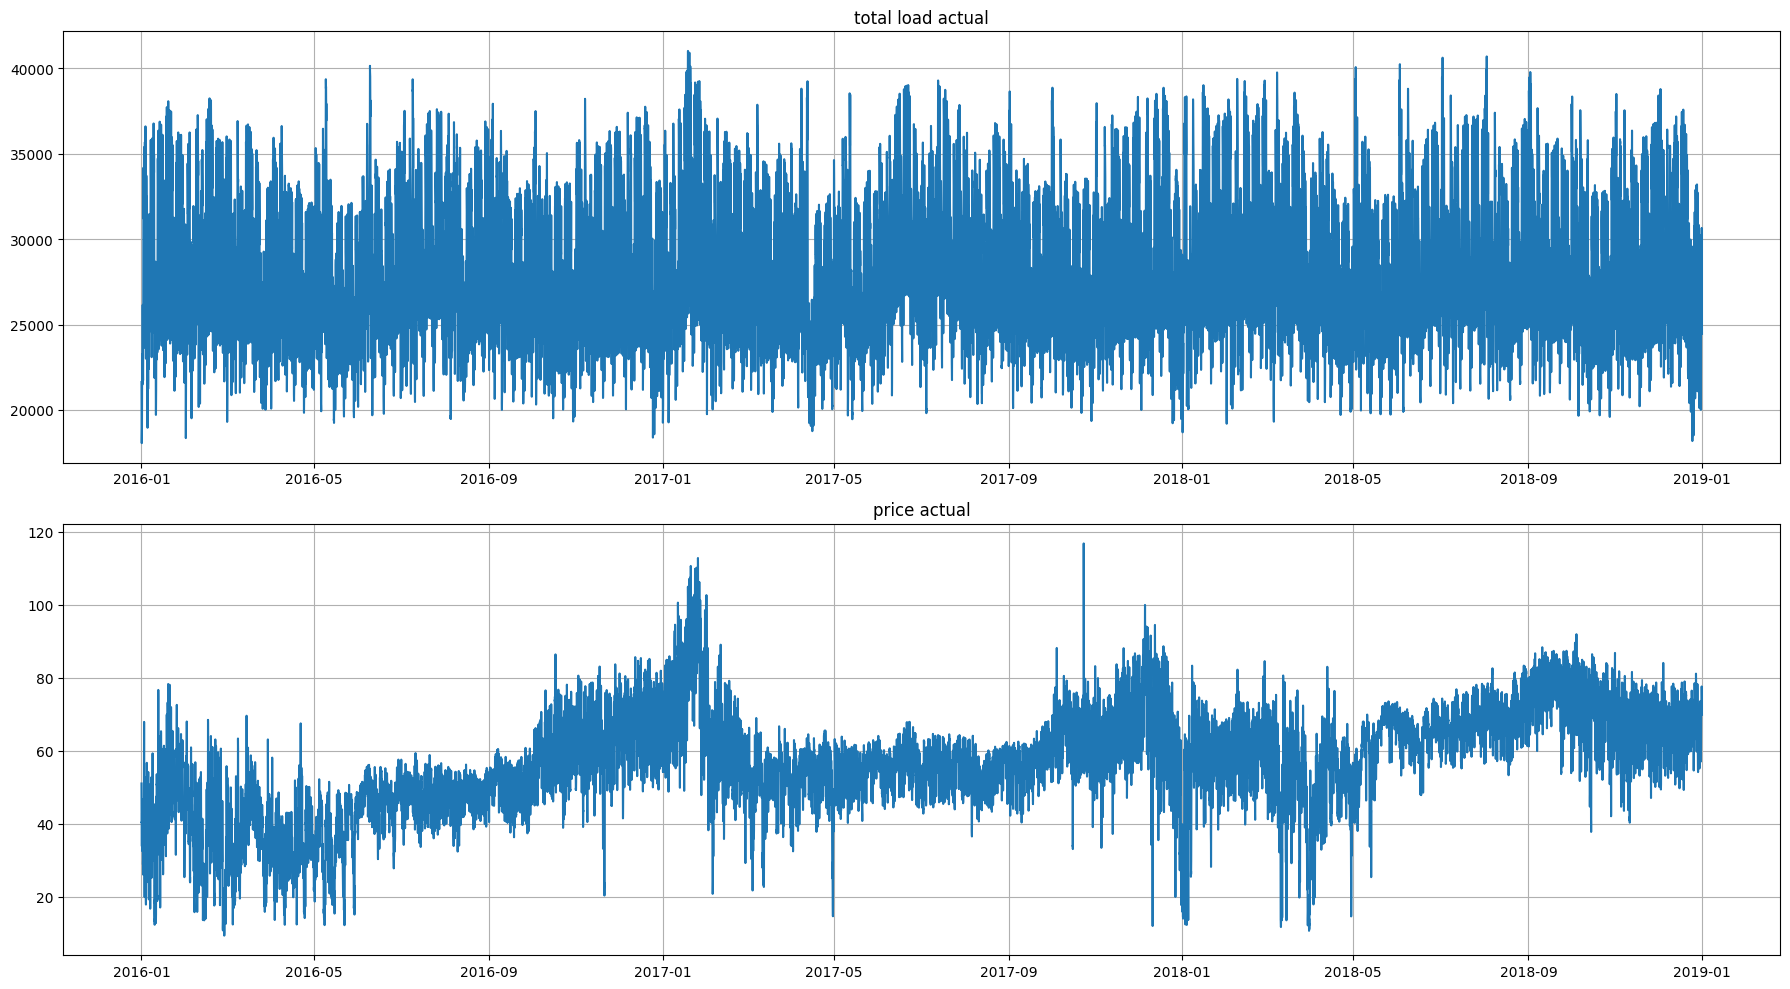

In [ ]:
##Visualizing Data

fig, axs = plt.subplots(len(df.columns), 1, figsize=(18, 10)) # Changed the first argument to len(df.columns)

for i, col in enumerate(df.columns):
    axs[i].plot(df[col])
    axs[i].set_title(col)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

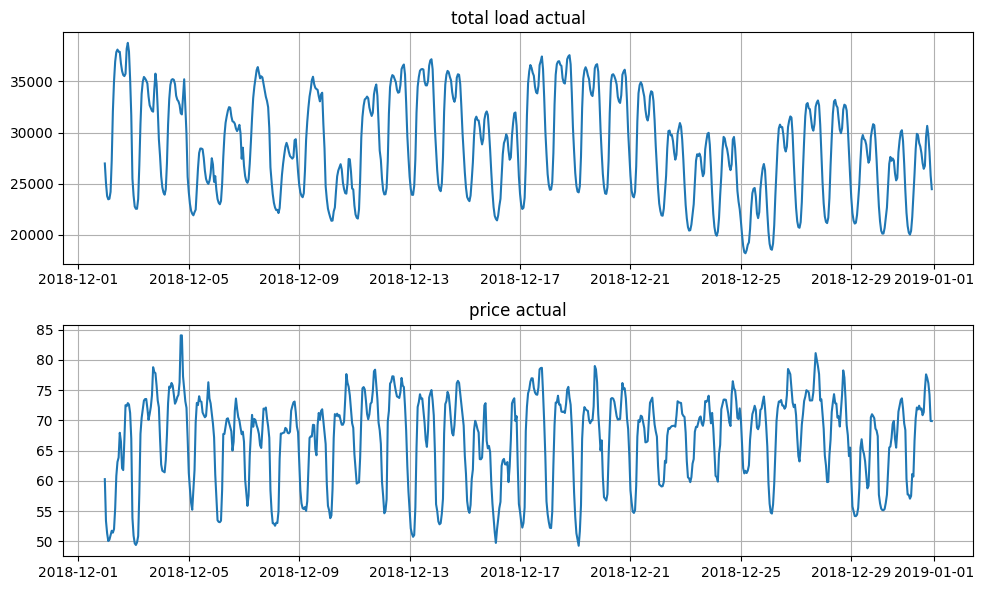

In [ ]:
# Visualize a few data at the end
fig, axs = plt.subplots(len(df.columns), 1, figsize=(10, 6))

for i, col in enumerate(df.columns):
    axs[i].plot(df[col][-24*30:])
    axs[i].set_title(col)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

There are clear seasonality, adding time features can high likely help models to capture these patterns.

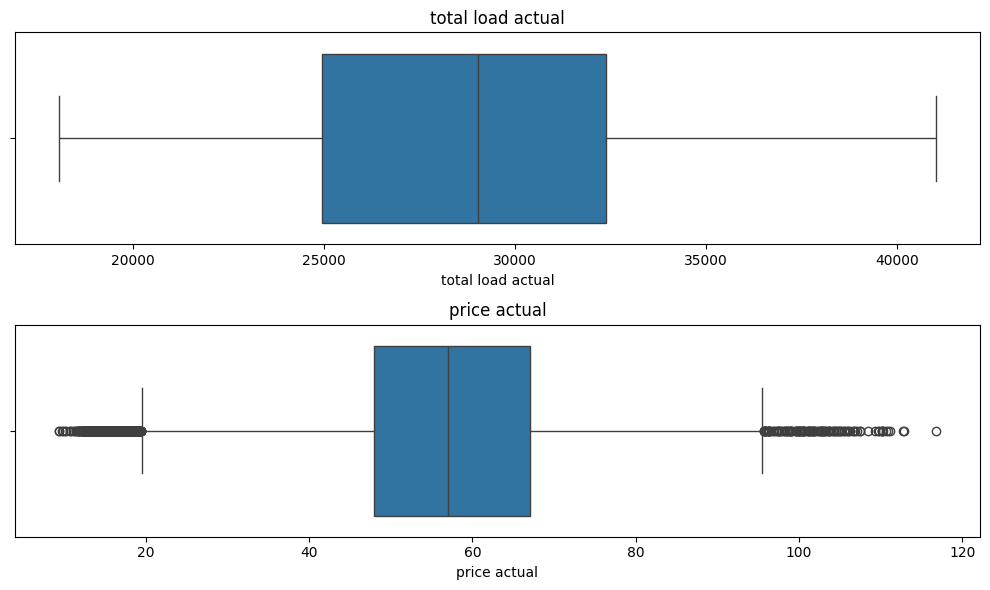

In [ ]:
# Check outliers
fig, axs = plt.subplots(len(df.columns), 1, figsize=(10,6))

for i, col in enumerate(df.columns):
    sns.boxplot(x=df[col], ax=axs[i])
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

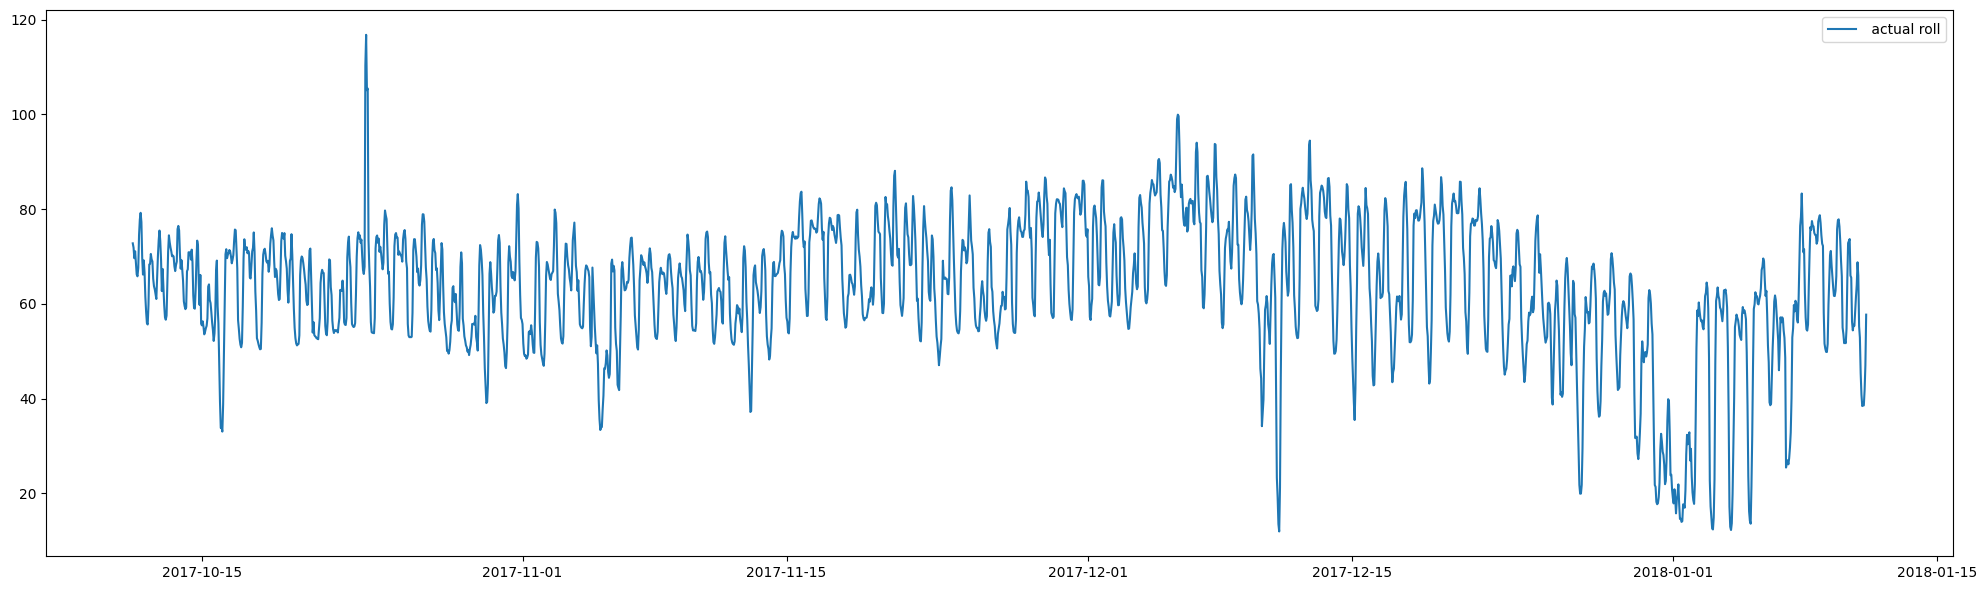

In [ ]:
# Visualize the outliers
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(df[(df.index > '2017-10-11 07:00:00') & (df.index < '2018-01-11 07:00:00')]['price actual'], label=' actual roll')

plt.legend()
plt.tight_layout()
plt.show()

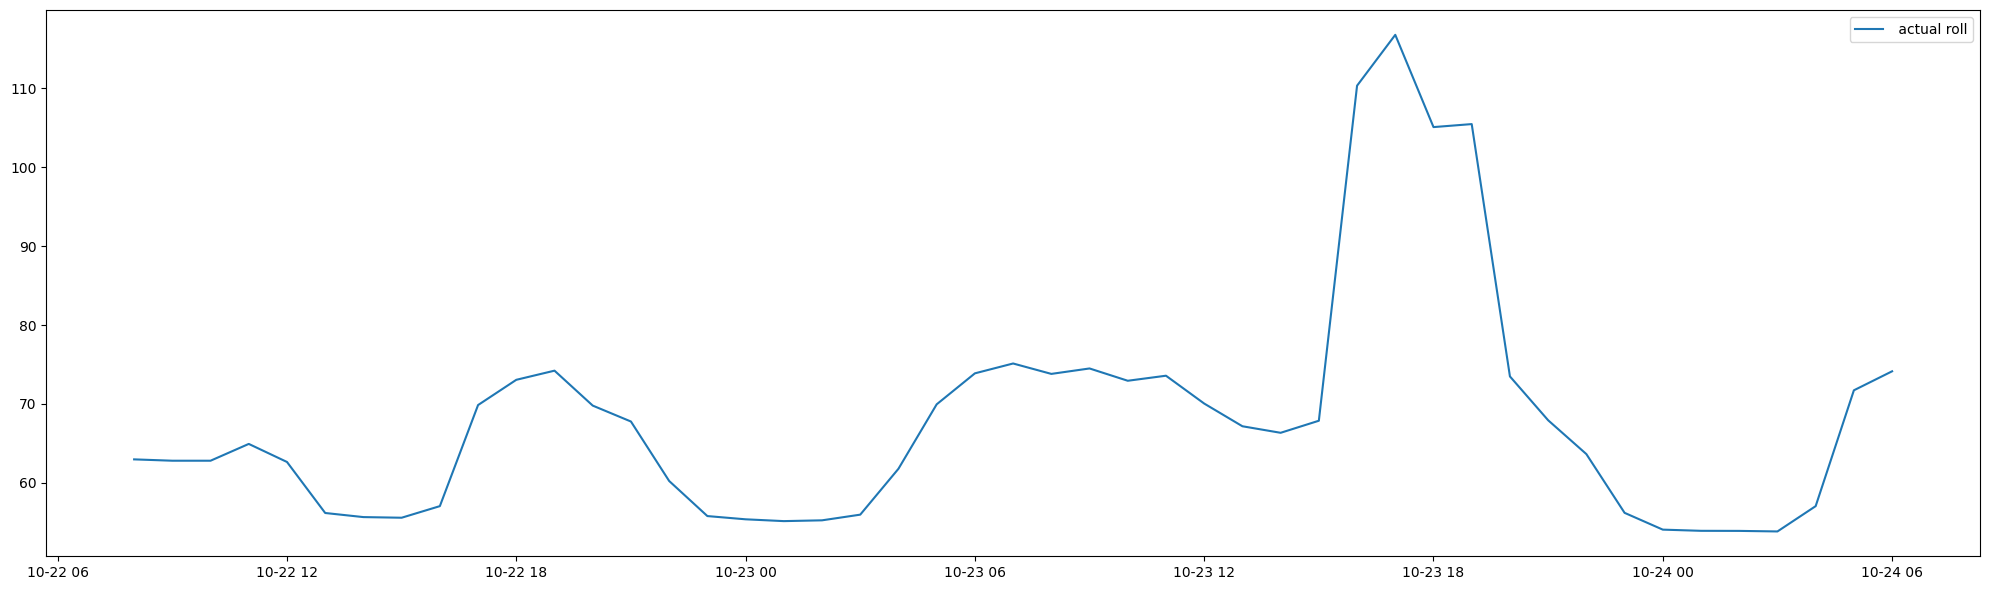

In [ ]:
# Visualize the outliers
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(df[(df.index > '2017-10-22 07:00:00') & (df.index < '2017-10-24 07:00:00')]['price actual'], label=' actual roll')

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total load actual,26303.0,28810.257138,4545.474497,18054.00,24932.50,29016.0,32371.00,41015.0
price actual,26303.0,56.726108,14.592461,9.33,47.99,57.0,67.02,116.8


The features are on different scales, so we need to apply scaling.

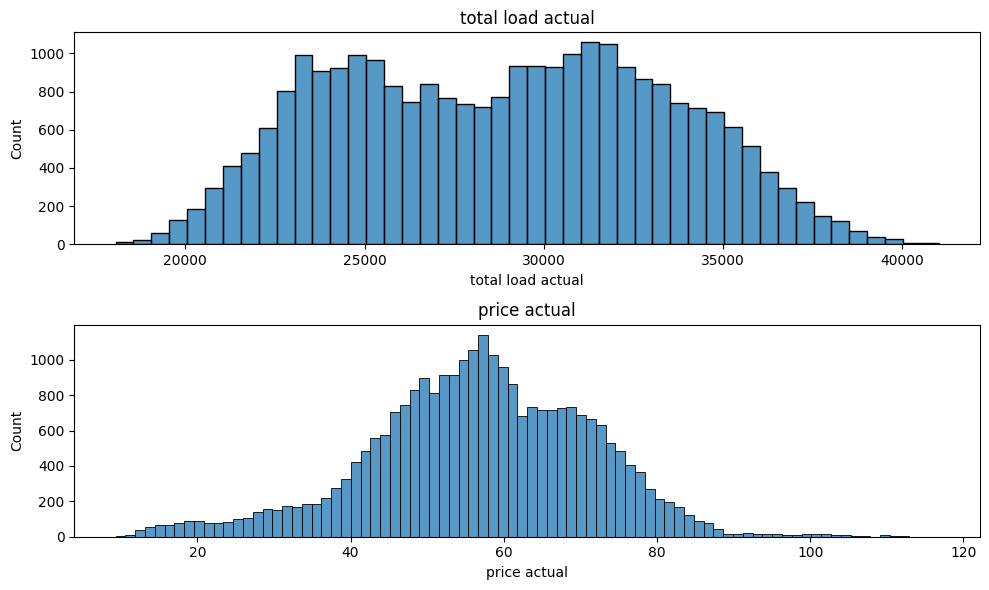

In [ ]:
# Distribution
fig, axs = plt.subplots(len(df.columns), 1, figsize=(10,6))

for i, col in enumerate(df.columns):
    sns.histplot(x=df[col], ax=axs[i])
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

## 3. Feature Engineering

In [ ]:

def add_time_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    return df

df = add_time_features(df)

In [ ]:
df.head()

,total load actual,price actual,hour,dayofweek
time,,,,
2016-01-01 00:00:00,21632.0,51.03,0,4
2016-01-01 01:00:00,20357.0,45.44,1,4
2016-01-01 02:00:00,19152.0,40.31,2,4
2016-01-01 03:00:00,18310.0,40.50,3,4
2016-01-01 04:00:00,18054.0,40.26,4,4


In [ ]:
# Correlation
df.corr()

,total load actual,price actual,hour,dayofweek
total load actual,1.000000,0.409105,0.394732,-0.196502
price actual,0.409105,1.000000,0.212474,-0.157526
hour,0.394732,0.212474,1.000000,0.000095
dayofweek,-0.196502,-0.157526,0.000095,1.000000


<Axes: xlabel='price actual rolling'>

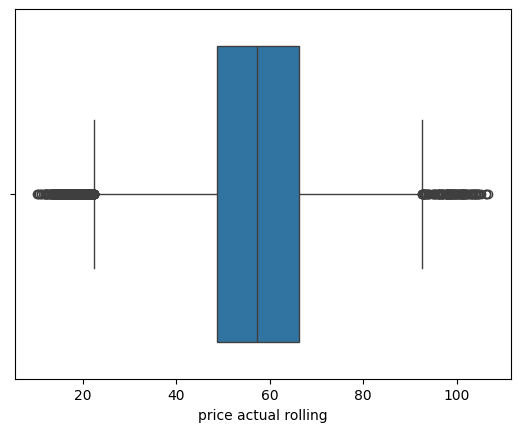

In [ ]:
## Feature Seclection

original_cols = ['total load actual', 'price actual']

## Smooth features
rolling_size = 8
for col in original_cols:
    df[f'{col} rolling'] = df[col].rolling(window=rolling_size).mean()
df.dropna(inplace=True)
# We use the rolling values and original values as input variables
rolling_columns = ['total load actual rolling', 'price actual rolling',]


sns.boxplot(x=df['price actual rolling'])

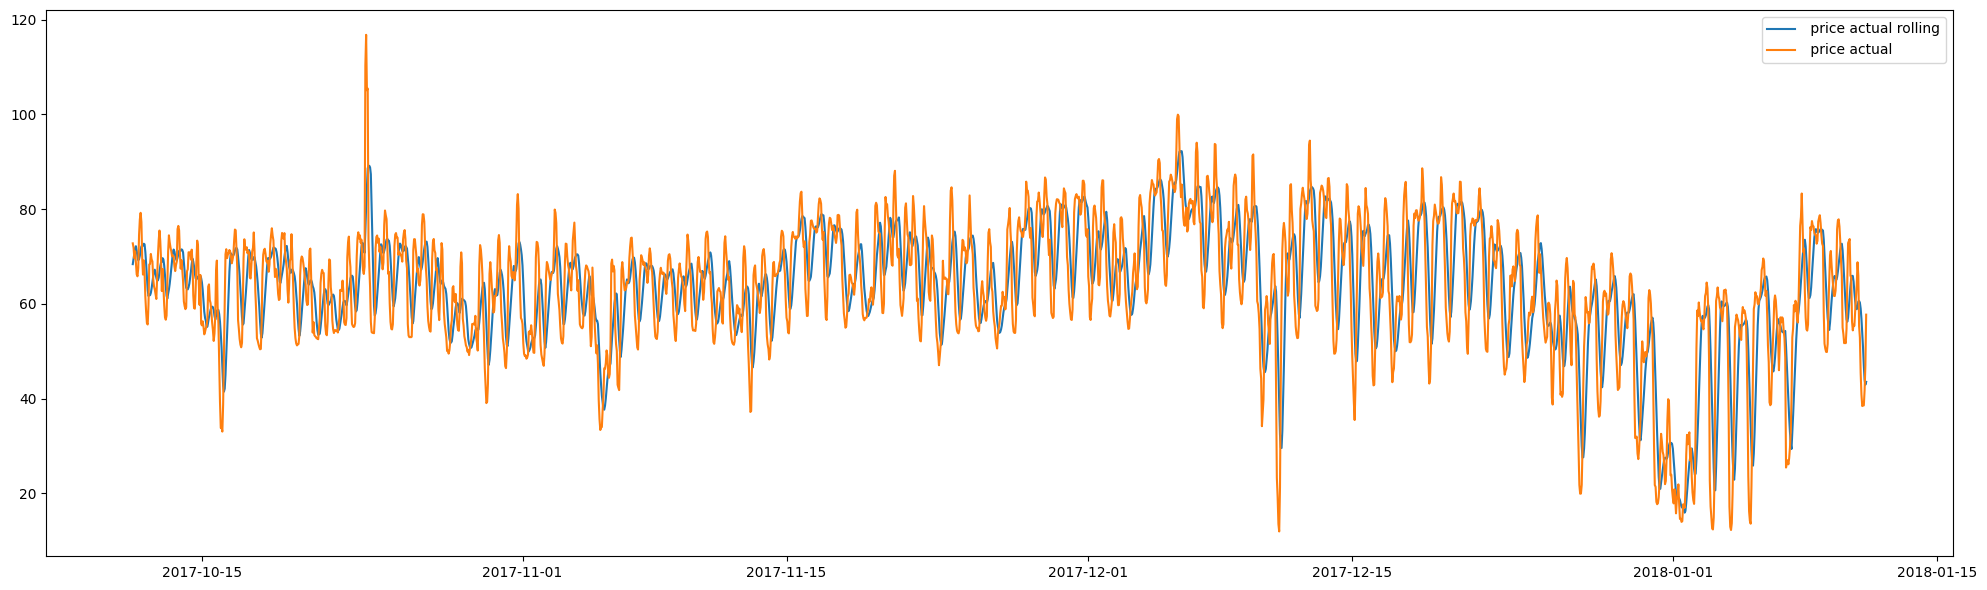

In [ ]:
# Visualize the outliers
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(df[(df.index > '2017-10-11 07:00:00') & (df.index < '2018-01-11 07:00:00')]['price actual rolling'], label=' price actual rolling')
ax.plot(df[(df.index > '2017-10-11 07:00:00') & (df.index < '2018-01-11 07:00:00')]['price actual'], label=' price actual')

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
## Train Test Split
split_step = int(df.shape[0]*0.8)
train = df.iloc[:split_step].copy()
ver = df.iloc[split_step:].copy()
valid = ver.iloc[:int(ver.shape[0]*0.5)].copy()
test = ver.iloc[int(ver.shape[0]*0.5):].copy()

## Scaling

# Initialize the scalers
rolling_scaler = MinMaxScaler()
load_scaler = MinMaxScaler()
price_scaler = MinMaxScaler()

# Avoid SettingWithCopyWarning by assigning results directly back to the DataFrame
for col in rolling_columns:
    train.loc[:,f'{col} scaled'] = rolling_scaler.fit_transform(train[[col]].copy())
    valid.loc[:,f'{col} scaled'] = rolling_scaler.transform(valid[[col]].copy())
    test.loc[:,f'{col} scaled'] = rolling_scaler.transform(test[[col]].copy())

train.loc[:,'total load actual scaled'] = load_scaler.fit_transform(train[['total load actual']].copy())
train.loc[:,'price actual scaled'] = price_scaler.fit_transform(train[['price actual']].copy())
valid.loc[:,'total load actual scaled'] = load_scaler.transform(valid[['total load actual']].copy())
valid.loc[:,'price actual scaled'] = price_scaler.transform(valid[['price actual']].copy())
test.loc[:,'total load actual scaled'] = load_scaler.transform(test[['total load actual']].copy())
test.loc[:,'price actual scaled'] = price_scaler.transform(test[['price actual']].copy())



train.drop(['total load actual rolling', 'price actual rolling'], axis=1, inplace=True)
valid.drop(['total load actual rolling', 'price actual rolling'], axis=1, inplace=True)
test.drop(['total load actual rolling', 'price actual rolling'], axis=1, inplace=True)

# Final, we get the datasets ready for michine learning
train_s = train.drop(['total load actual', 'price actual'], axis=1)
valid_s = valid.drop(['total load actual', 'price actual'], axis=1)
test_s = test.drop(['total load actual', 'price actual'], axis=1)


In [ ]:
train_s.head()

,hour,dayofweek,total load actual rolling scaled,price actual rolling scaled,total load actual scaled,price actual scaled
time,,,,,,
2016-01-01 07:00:00,7,4,0.016258,0.308915,0.008340,0.228436
2016-01-01 08:00:00,8,4,0.000000,0.293646,0.026034,0.278403
2016-01-01 09:00:00,9,4,0.000768,0.290341,0.094074,0.312273
2016-01-01 10:00:00,10,4,0.016802,0.291754,0.152363,0.298409
2016-01-01 11:00:00,11,4,0.042773,0.292350,0.187751,0.294315


In [ ]:
train_s.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21036 entries, 2016-01-01 07:00:00 to 2018-05-26 18:00:00
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   hour                              21036 non-null  int32  
 1   dayofweek                         21036 non-null  int32  
 2   total load actual rolling scaled  21036 non-null  float64
 3   price actual rolling scaled       21036 non-null  float64
 4   total load actual scaled          21036 non-null  float64
 5   price actual scaled               21036 non-null  float64
dtypes: float64(4), int32(2)
memory usage: 986.1 KB


In [ ]:
train_s = train_s.astype(np.float32)
valid_s = valid_s.astype(np.float32)
test_s = test_s.astype(np.float32)

In [ ]:
train_s.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21036 entries, 2016-01-01 07:00:00 to 2018-05-26 18:00:00
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   hour                              21036 non-null  float32
 1   dayofweek                         21036 non-null  float32
 2   total load actual rolling scaled  21036 non-null  float32
 3   price actual rolling scaled       21036 non-null  float32
 4   total load actual scaled          21036 non-null  float32
 5   price actual scaled               21036 non-null  float32
dtypes: float32(6)
memory usage: 657.4 KB


## 3. Feature Engineering & Model Training



```
window_size = 3

dataset = tf.data.Dataset.from_tensor_slices(train)
dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)

dataset = dataset.flat_map(lambda window: window.batch(window_size+1))

for window in dataset.take(1):
  print(window.numpy())
  print(f'shape: {window.numpy().shape}')

[[  0.482  247.138    0.       0.       0.       0.484 ]
 [  0.4824 247.212    0.       0.       0.       0.484 ]
 [  0.4824 247.364    0.       0.       0.       0.482 ]
 [  0.4828 247.564    0.       0.       0.       0.482 ]]
shape: (4, 6)

for window in dataset.take(1):
  print(window[:-1,:-1], window[-1][-1])

tf.Tensor(
[[  0.482  247.138    0.       0.       0.    ]
 [  0.4824 247.212    0.       0.       0.    ]
 [  0.4824 247.364    0.       0.       0.    ]], shape=(3, 5), dtype=float64) tf.Tensor(0.482, shape=(), dtype=float64)

# group into features and lables
dataset = dataset.map(lambda window: (window[:-1,:-1], window[-1][-1]))

for x, y in dataset.take(2):
  print('x = ', x.numpy())
  print('y = ', y.numpy())
  print()

x =  [[  0.482  247.138    0.       0.       0.    ]
 [  0.4824 247.212    0.       0.       0.    ]
 [  0.4824 247.364    0.       0.       0.    ]]
y =  0.482

x =  [[  0.4824 247.212    0.       0.       0.    ]
 [  0.4824 247.364    0.       0.       0.    ]
 [  0.4828 247.564    0.       0.       0.    ]]
y =  0.482
```



### Single Step (CNN-LSTM-DNN)

In [ ]:
def single_step_windowed_dataset(series, window_size, batch_size, shuffle_buffer_size, input_columns, output_columns, column_names):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series, not necessarily univariate
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer_size (int) - buffer size to use for the shuffle method
      input_columns (list of str, or ints) - the names or indices of the columns to be used as features
      output_columns (str, or ints) - the names or indices of the columns to be used as labels
      column_names (list of str, optional) - the names of the columns in the series

    Returns:
      dataset (TF Dataset) - TF Dataset containing Xs and ys.
    """

    # If column names are provided, map feature_columns and label_columns from names to indices
    if column_names is not None:
        input_columns = [column_names.index(col) if isinstance(col, str) else col for col in input_columns]
        output_columns = [column_names.index(col) if isinstance(col, str) else col for col in output_columns]
    else:
        # If no column names are provided, assume feature_columns and label_columns are indices
        raise ValueError(f"column_names are missing")

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with specified features and label
    dataset = dataset.map(lambda window: (tf.gather(window[:-1], input_columns, axis=-1),
                                          tf.gather(window[-1], output_columns, axis=-1))) # -1 refers to single step method, we only forecast the next time step

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer_size)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

#### Single Step Single Output + Autoregressive


In [ ]:
# Price
# Build CNN-LSTM-DNN Model

def create_uncompiled_price_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=4, strides=1, padding='causal', activation='relu',
                              input_shape=[window_size, len(input_cols)]),
        #tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(32, return_sequences=False),
        #tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(1),
    ])
    return model



def adjust_price_learning_rate(dataset):
    model = create_uncompiled_price_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-1 * 10**(-epoch / 6))
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)

    # Compile the model
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    # Train the model
    history = model.fit(dataset, epochs=20, callbacks=[lr_schedule])

    return history


def create_price_model(initial_lr=1e-1):

    # Set the initial learning rate
    initial_learning_rate=initial_lr

    # Define the scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=400,
        decay_rate=0.8,
        staircase=True)

    # Set the optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

    model = create_uncompiled_price_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    return model


def model_forecast(model, test_series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the input variables
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size
    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(test_series) #separate out the label

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast



In [ ]:

column_names = train_s.columns.to_list()
input_cols = train_s.columns.to_list()
output_cols = ['price actual scaled']
window_size = 24 * 2
batch_size = 32
shuffle_buffer_size = 24*100 # this value depends on the size of the data, around the len(data) for small data and smaller len(data) for big data


train_price_set = single_step_windowed_dataset(series=train_s,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer_size=shuffle_buffer_size,
                             input_columns=input_cols,
                             output_columns=output_cols,
                             column_names=column_names)

validation_price_set = single_step_windowed_dataset(series=valid_s,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer_size=shuffle_buffer_size,
                             input_columns=input_cols,
                             output_columns=output_cols,
                             column_names=column_names)

In [ ]:
single_step_single_output_price_model = create_price_model(initial_lr=1e-1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=8, restore_best_weights=True)


history = single_step_single_output_price_model.fit(train_price_set, validation_data=validation_price_set, epochs=20, callbacks=[early_stopping])


Epoch 1/20
    655/Unknown 25s 33ms/step - loss: 0.0086 - mae: 0.0931

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


656/656 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step - loss: 0.0086 - mae: 0.0931 - val_loss: 0.0044 - val_mae: 0.0823
Epoch 2/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - loss: 0.0036 - mae: 0.0656 - val_loss: 7.0892e-04 - val_mae: 0.0297
Epoch 3/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - loss: 0.0018 - mae: 0.0467 - val_loss: 0.0013 - val_mae: 0.0432
Epoch 4/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - loss: 0.0011 - mae: 0.0368 - val_loss: 5.4386e-04 - val_mae: 0.0263
Epoch 5/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - loss: 9.9596e-04 - mae: 0.0341 - val_loss: 5.0255e-04 - val_mae: 0.0253
Epoch 6/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - loss: 8.6962e-04 - mae: 0.0319 - val_loss: 5.8264e-04 - val_mae: 0.0272
Epoch 7/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 39s 37ms/step - loss: 8.2151e-04 - mae: 0.0310 - val_loss: 0.0010 - val_mae: 0.0361
Epoch 8/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - loss: 7.7186e-04 - mae: 0.0298 - val_loss: 5.5877e-04 - val_mae: 0.0266
Epoch 9/20
656/

In [ ]:
from tensorflow.keras.models import load_model

single_step_single_output_price_model = load_model('single step single output price model.h5')

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


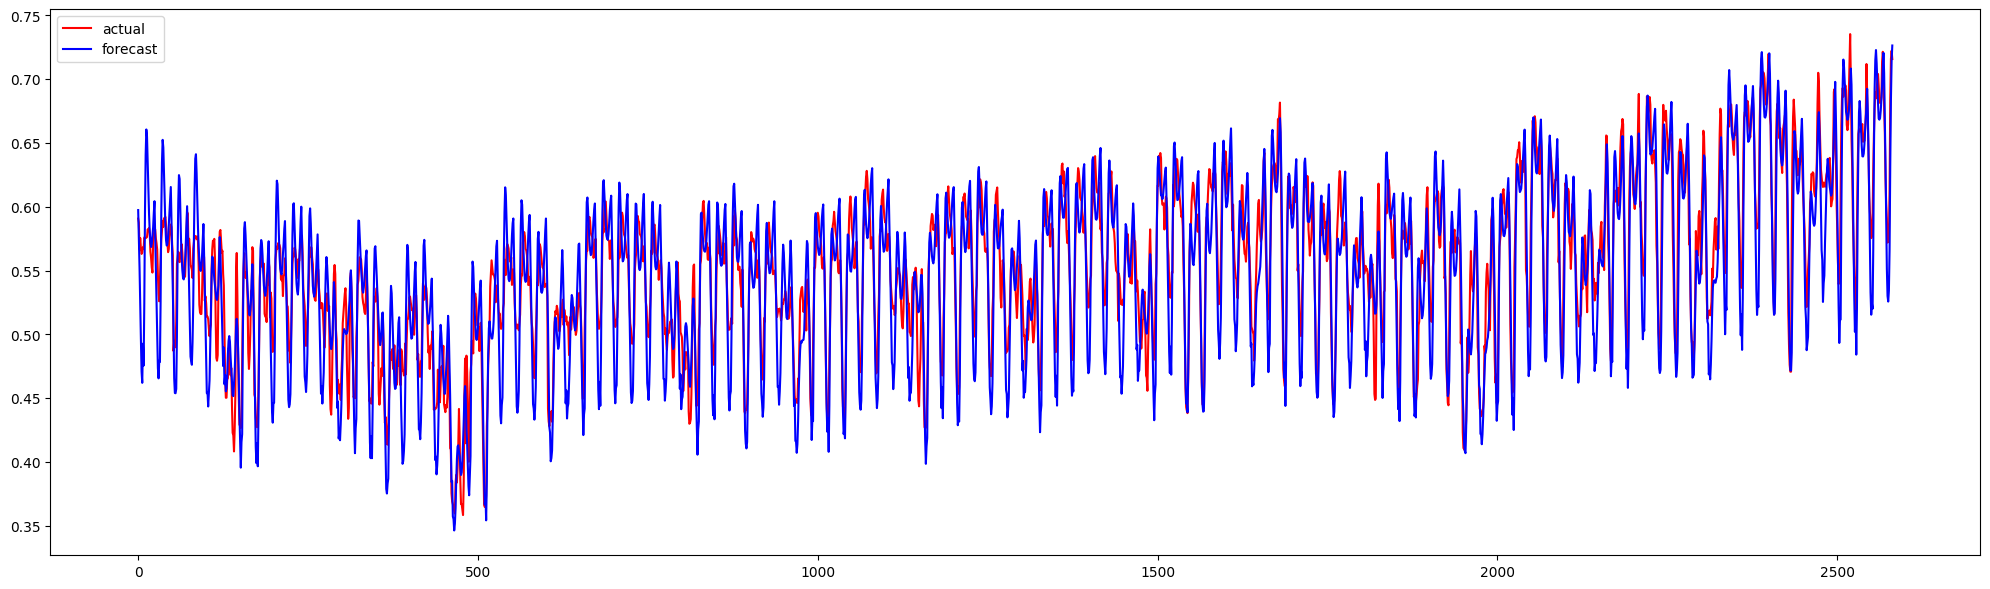

In [ ]:
price_forecast = model_forecast(single_step_single_output_price_model, valid_s, window_size, batch_size)


price_actual = valid_s.iloc[window_size:]['price actual scaled'].to_list()

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(price_actual[:], c='red', label='actual')
ax.plot(price_forecast[:-1], c= 'blue', label='forecast')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
price_mse = mean_squared_error(price_actual, price_forecast[:-1])
price_mae = mean_absolute_error(price_actual, price_forecast[:-1])

print(f'mse: {price_mse}')
print(f'mae: {price_mae}')

#single_step_single_output_price_model.save('single step single output price model.h5')

mse: 0.000934551792692608
mae: 0.02461020490349401


In [ ]:
# Load
def create_uncompiled_load_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='causal', activation='relu',
                              input_shape=[window_size, len(input_cols)]),
        #tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=False),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(1),
    ])
    return model


def adjust_load_learning_rate(dataset):
    model = create_uncompiled_load_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-1 * 10**(-epoch / 10))
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)

    # Compile the model
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    # Train the model
    history = model.fit(dataset, epochs=20, callbacks=[lr_schedule])

    return history


def create_load_model(initial_lr=1e-1):

    # Set the initial learning rate
    initial_learning_rate=initial_lr

    # Define the scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=435,
        decay_rate=0.95,
        staircase=True)

    # Set the optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

    model = create_uncompiled_load_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    return model

def model_forecast(model, test_series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the input variables
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size
    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(test_series) #separate out the label

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast



In [ ]:
column_names = train_s.columns.to_list()
input_cols = train_s.columns.to_list()
output_cols = ['total load actual scaled']
window_size = 24 * 2
batch_size = 32
shuffle_buffer_size = 24*100 # this value depends on the size of the data, around the len(data) for small data and smaller len(data) for big data

train_load_set = single_step_windowed_dataset(series=train_s,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer_size=shuffle_buffer_size,
                             input_columns=input_cols,
                             output_columns=output_cols,
                             column_names=column_names)

validation_load_set = single_step_windowed_dataset(series=valid_s,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer_size=shuffle_buffer_size,
                             input_columns=input_cols,
                             output_columns=output_cols,
                             column_names=column_names)

In [ ]:
single_step_single_output_load_model = create_load_model(initial_lr=1e-1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=8, restore_best_weights=True)



history = single_step_single_output_load_model.fit(train_load_set, validation_data=validation_load_set, epochs=40, callbacks=[early_stopping])

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    656/Unknown 53s 71ms/step - loss: 0.0139 - mae: 0.1264

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


656/656 ━━━━━━━━━━━━━━━━━━━━ 59s 80ms/step - loss: 0.0139 - mae: 0.1264 - val_loss: 0.0072 - val_mae: 0.0896
Epoch 2/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 80s 78ms/step - loss: 0.0064 - mae: 0.0873 - val_loss: 0.0030 - val_mae: 0.0600
Epoch 3/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 82s 78ms/step - loss: 0.0032 - mae: 0.0617 - val_loss: 0.0021 - val_mae: 0.0509
Epoch 4/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 83s 79ms/step - loss: 0.0026 - mae: 0.0563 - val_loss: 0.0023 - val_mae: 0.0532
Epoch 5/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 52s 79ms/step - loss: 0.0022 - mae: 0.0521 - val_loss: 0.0021 - val_mae: 0.0506
Epoch 6/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 51s 76ms/step - loss: 0.0021 - mae: 0.0510 - val_loss: 0.0019 - val_mae: 0.0499
Epoch 7/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 48s 73ms/step - loss: 0.0018 - mae: 0.0469 - val_loss: 0.0021 - val_mae: 0.0510
Epoch 8/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 87s 81ms/step - loss: 0.0018 - mae: 0.0466 - val_loss: 0.0019 - val_mae: 0.0475
Epoch 9/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 78s 75ms/st

In [ ]:
single_step_single_output_load_model = load_model('single step single output load model.h5')

81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


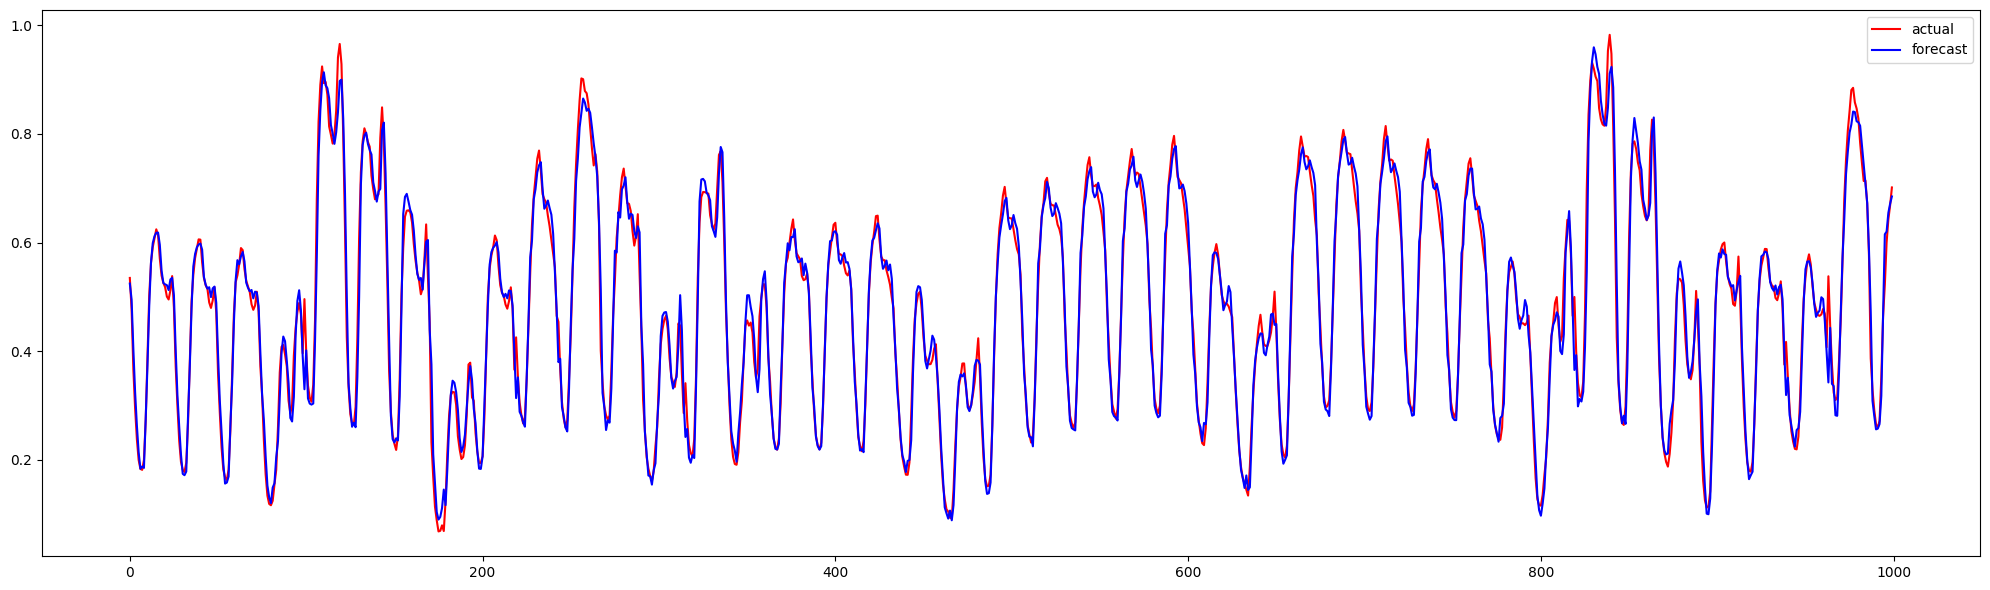

In [ ]:
load_forecast = model_forecast(single_step_single_output_load_model, valid_s, window_size, batch_size)

load_actual = valid_s.iloc[window_size:]['total load actual scaled'].to_list()

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(load_actual[:1000], c='red', label='actual')
ax.plot(load_forecast[:1000], c= 'blue', label='forecast')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
load_mse = mean_squared_error(load_actual, load_forecast[:-1])
load_mae = mean_absolute_error(load_actual, load_forecast[:-1])

print(f'mse: {load_mse}')
print(f'mae: {load_mae}')

#single_step_single_output_load_model.save('single step single output load model.h5')

mse: 0.0008202444431818116
mae: 0.02072424851906198


Forecast

In [ ]:
test_s.shape

(2630, 6)

In [ ]:
test_s.columns

Index(['hour', 'dayofweek', 'total load actual rolling scaled',
       'price actual rolling scaled', 'total load actual scaled',
       'price actual scaled'],
      dtype='object')

In [ ]:
import numpy as np
from joblib import Parallel, delayed
import time

def forecast_single_window(last_step, test_data, model_load, model_price, forecast_size, window_size, rolling_size):
    # Extract the last window of data for this forecast
    last_rows = test_data[last_step - window_size:last_step]
    input_data = last_rows.values.reshape(1, window_size, last_rows.shape[1])

    # Initialize rolling buffers as NumPy arrays
    roll_load_buffer = np.array(last_rows['total load actual scaled'].values[-(rolling_size - 1):])  # Using column index 2
    roll_price_buffer = np.array(last_rows['price actual scaled'].values[-(rolling_size - 1):])  # Using column index 3

    # Initialize the current time based on the last row of last_rows
    current_time = last_rows.index[-1]  # Assuming the index of test_data contains the timestamp

    forecast_steps = []

    for _ in range(forecast_size):
        # Predict the next load and price
        next_load = model_load.predict(input_data)
        next_price = model_price.predict(input_data)

        # Collect predictions
        forecast_steps.append((next_load[0][0], next_price[0][0]))

        # Update rolling buffers
        roll_load_buffer = np.roll(roll_load_buffer, -1)
        roll_load_buffer[-1] = next_load[0][0]

        roll_price_buffer = np.roll(roll_price_buffer, -1)
        roll_price_buffer[-1] = next_price[0][0]

        # Calculate new rolling scaled values
        total_load_roll_scaled = np.mean(roll_load_buffer)
        price_roll_scaled = np.mean(roll_price_buffer)

        # Update time for next prediction
        current_time += pd.Timedelta(hours=1)  # Increment the current time by 1 hour
        new_hour = current_time.hour
        new_dayofweek = current_time.dayofweek

        # Prepare next input
        next_input = np.array([[new_hour, new_dayofweek, total_load_roll_scaled, price_roll_scaled,
                                next_load[0][0], next_price[0][0]]])
        input_data = np.append(input_data[:, 1:, :], [next_input], axis=1)

    return forecast_steps

# Example usage:

forecast_size = 24  # Forecasting the next 24 hours
window_size = 48  # Using the last 48 hours for the input window
rolling_size = 3  # Keeping a rolling buffer of the last 3 values
test_data = test_s[:window_size+forecast_size+24*7]  # Adjusting test data size

start_time = time.time()
# Parallelize the forecast
predictions = Parallel(n_jobs=-1)(delayed(forecast_single_window)(last_step, test_data, single_step_single_output_load_model,
                                                                  single_step_single_output_price_model, forecast_size,
                                                                  window_size, rolling_size)
                                  for last_step in range(window_size, len(test_data) - forecast_size))

end_time = time.time()
print(f"Total running time: {end_time - start_time} seconds")

Total running time: 158.464674949646 seconds


In [ ]:
predictions = np.array(predictions)
predictions.shape

(30, 24, 2)

In [ ]:
predictions[0,:,0]

array([ 0.50772214,  0.5861285 ,  0.6288538 ,  0.6495724 ,  0.68565243,
        0.72754973,  0.75696474,  0.79037046,  0.81419706,  0.81243396,
        0.77779007,  0.69430375,  0.5667908 ,  0.4236083 ,  0.28464773,
        0.16312072,  0.04734498, -0.04808211, -0.11721563, -0.14782116,
       -0.12522805, -0.09557074, -0.04199874,  0.01141059], dtype=float32)

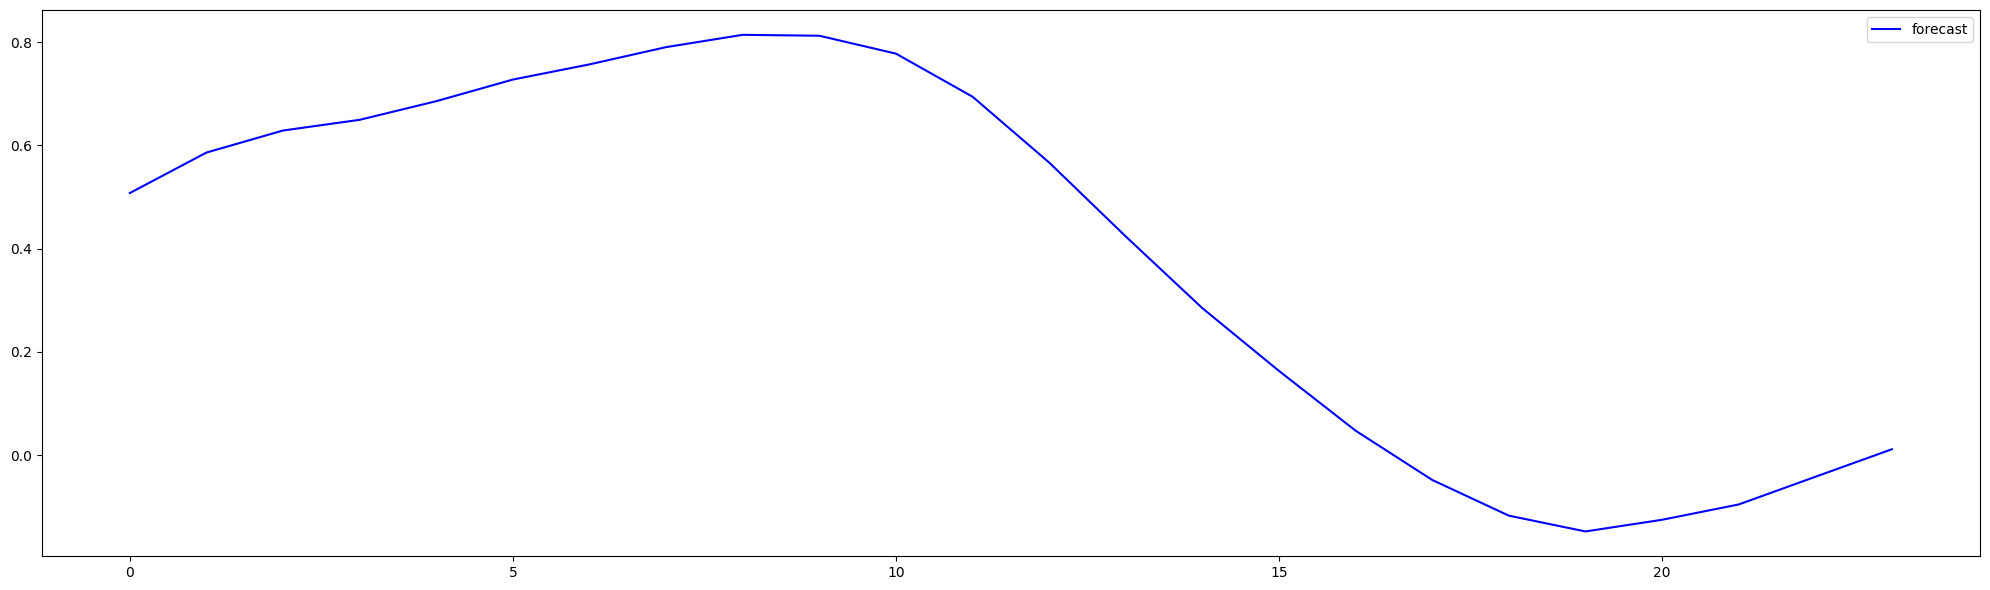

In [ ]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(predictions[0,:,0], c= 'blue', label='forecast')
plt.legend()
plt.tight_layout()
plt.show()

####Single Step Multi-Output + Autoregressive

In [ ]:
column_names = train_s.columns.to_list()
input_cols = ['total load actual_roll_scaled', 'price actual_roll_scaled']
output_cols = ['total load actual scaled', 'price actual scaled']
window_size = 24 * 2
batch_size = 32
shuffle_buffer_size = 10000 # this value depends on the size of the data, around the len(data) for small data and smaller len(data) for big data

train_set = single_step_windowed_dataset(train_s, window_size, batch_size, shuffle_buffer_size, input_columns=input_cols, output_columns=output_cols, column_names=column_names)

```
for windows in train_set.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 48, 2)
shape of second element: (32, 2)
```

In [ ]:
# Build CNN-LSTM-DNN Model
def create_uncompiled_model():
# Build CNN-LSTM-DNN Model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', activation='relu',
                              input_shape=[window_size, len(input_cols)]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(32, return_sequences=False),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(2),
    ])
    return model

def adjust_learning_rate(dataset):
    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 2))
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)

    # Compile the model
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    # Train the model
    history = model.fit(dataset, epochs=10, callbacks=[lr_schedule])

    return history



In [ ]:
lr_history = adjust_learning_rate(train_set)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


437/437 ━━━━━━━━━━━━━━━━━━━━ 30s 51ms/step - loss: 0.1113 - mae: 0.4405 - learning_rate: 1.0000e-05
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


437/437 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - loss: 0.0928 - mae: 0.3949 - learning_rate: 3.1623e-05
Epoch 3/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - loss: 0.0614 - mae: 0.3101 - learning_rate: 1.0000e-04
Epoch 4/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - loss: 0.0279 - mae: 0.2053 - learning_rate: 3.1623e-04
Epoch 5/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - loss: 0.0136 - mae: 0.1284 - learning_rate: 0.0010
Epoch 6/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 39s 51ms/step - loss: 0.0132 - mae: 0.1258 - learning_rate: 0.0032
Epoch 7/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - loss: 0.0128 - mae: 0.1240 - learning_rate: 0.0100
Epoch 8/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - loss: 0.0115 - mae: 0.1161 - learning_rate: 0.0316
Epoch 9/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - loss: 0.0083 - mae: 0.0976 - learning_rate: 0.1000
Epoch 10/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - loss: 0.0041 - mae: 0.0681 - learning_rate: 0.3162


(1e-05, 1.0, 0.0, 0.1)

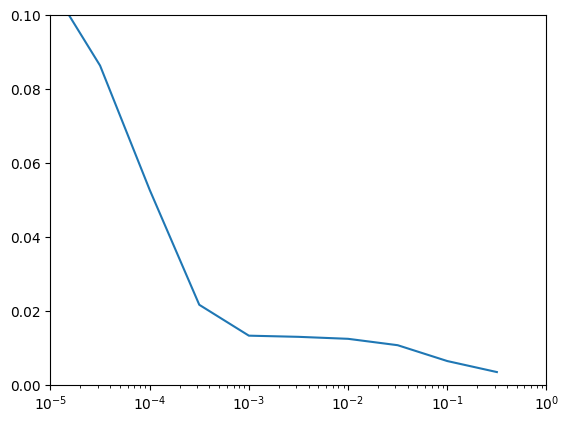

In [ ]:
plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])
plt.axis([1e-5, 1, 0, 0.1])

In [ ]:
def create_model(initial_lr=1e-1):

    # Set the initial learning rate
    initial_learning_rate=initial_lr

    # Define the scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=200,
        decay_rate=0.9,
        staircase=True)

    # Set the optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

    model = create_uncompiled_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    return model


single_step_multi_output_model = create_model()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)

validation_set = single_step_windowed_dataset(series=valid_s,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer_size=shuffle_buffer_size,
                             input_columns=input_cols,
                             output_columns=output_cols,
                             column_names=column_names)

history = single_step_multi_output_model.fit(train_set, validation_data=validation_set, epochs=25, callbacks=[early_stopping])

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    437/Unknown 27s 49ms/step - loss: 0.0166 - mae: 0.1405

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


437/437 ━━━━━━━━━━━━━━━━━━━━ 29s 54ms/step - loss: 0.0166 - mae: 0.1405 - val_loss: 0.0089 - val_mae: 0.1030
Epoch 2/25
437/437 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - loss: 0.0082 - mae: 0.0979 - val_loss: 0.0056 - val_mae: 0.0813
Epoch 3/25
437/437 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - loss: 0.0054 - mae: 0.0789 - val_loss: 0.0032 - val_mae: 0.0627
Epoch 4/25
437/437 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - loss: 0.0044 - mae: 0.0713 - val_loss: 0.0028 - val_mae: 0.0583
Epoch 5/25
437/437 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - loss: 0.0038 - mae: 0.0664 - val_loss: 0.0026 - val_mae: 0.0562
Epoch 6/25
437/437 ━━━━━━━━━━━━━━━━━━━━ 27s 58ms/step - loss: 0.0031 - mae: 0.0592 - val_loss: 0.0021 - val_mae: 0.0490
Epoch 7/25
437/437 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - loss: 0.0027 - mae: 0.0554 - val_loss: 0.0019 - val_mae: 0.0470
Epoch 8/25
437/437 ━━━━━━━━━━━━━━━━━━━━ 26s 56ms/step - loss: 0.0025 - mae: 0.0524 - val_loss: 0.0018 - val_mae: 0.0468
Epoch 9/25
437/437 ━━━━━━━━━━━━━━━━━━━━ 26s 56ms/st

In [ ]:
def model_forecast(model, series, feature_columns, window_size, batch_size):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series, not necessarily univariate
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      feature_columns (list of str or int) - the names or indices of the columns to be used as features
      column_names (list of str, optional) - the names of the columns in the series

    Returns:
      Forecast
    """


    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series[feature_columns])

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size))

    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast


In [ ]:
output_cols=['total load actual scaled', 'price actual scaled']
series = valid_s.drop(output_cols, axis=1).copy()

forecast = model_forecast(model=single_step_multi_output_model, series=series, feature_columns=input_cols, window_size=window_size, batch_size=batch_size)

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


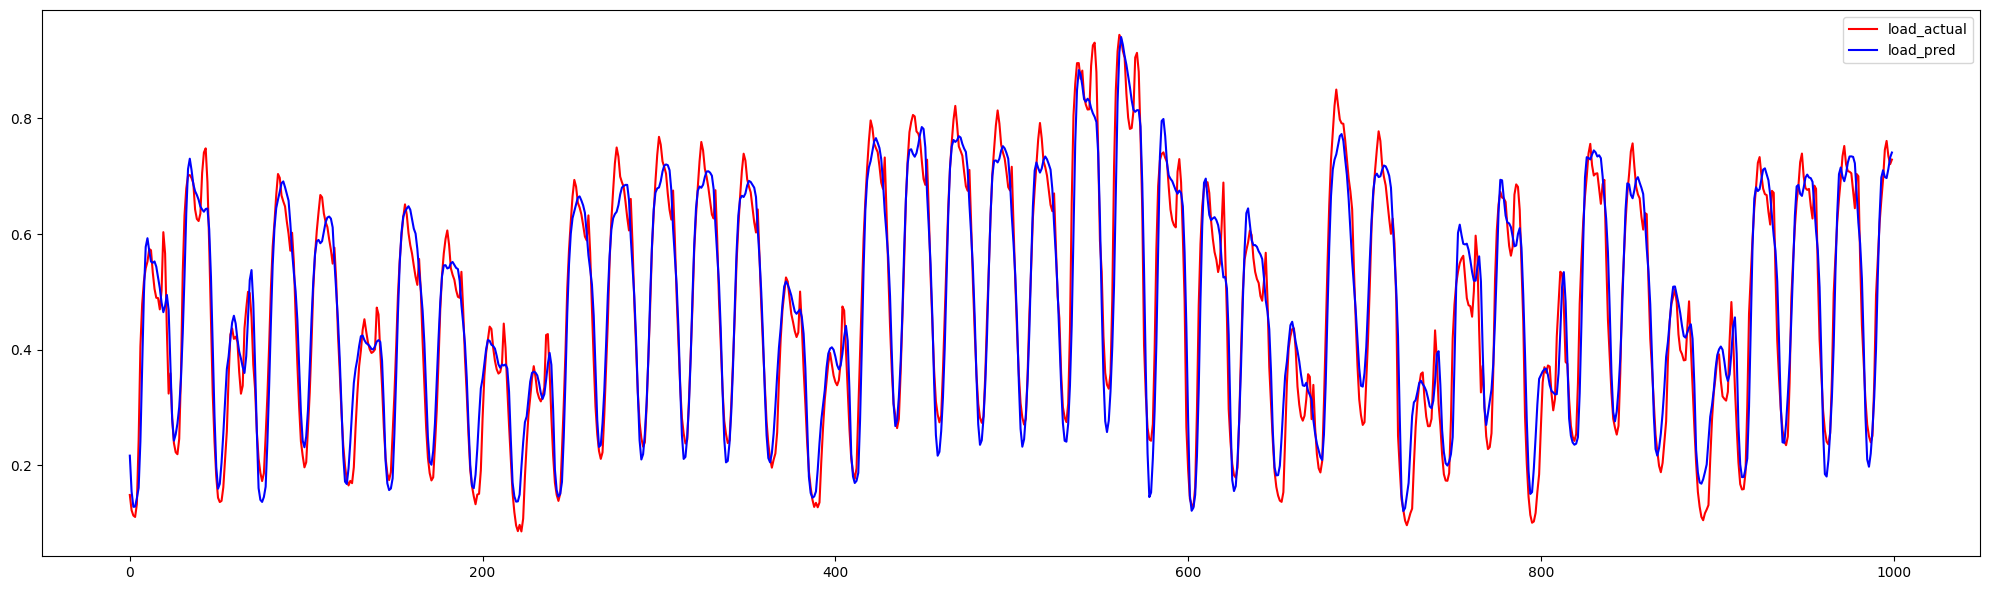

In [ ]:
price_pred = forecast[:-1,0]
actual = valid_s['total load actual scaled'][window_size:].to_list()

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(actual[:1000], c='red', label='load_actual')
ax.plot(price_pred[:1000], c= 'blue', label='load_pred')
plt.legend()
plt.tight_layout()
plt.show()

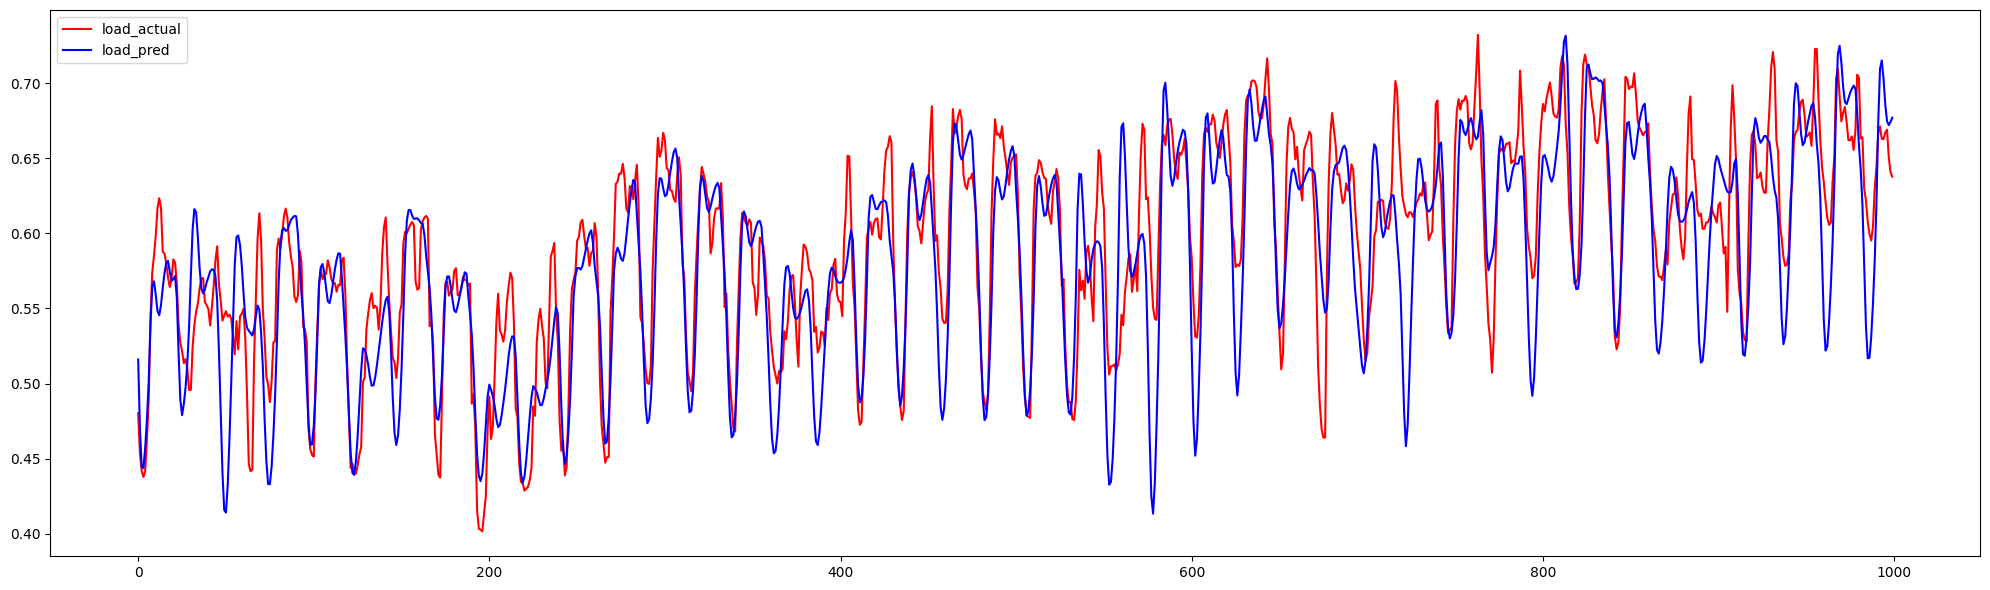

In [ ]:
price_pred = forecast[:-1,1]
actual = valid_s['price actual scaled'][window_size:].to_list()

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(actual[:1000], c='red', label='load_actual')
ax.plot(price_pred[:1000], c= 'blue', label='load_pred')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
single_step_multi_output_model.save('single_step_multi_output_model.h5')

In [ ]:
actual = valid_s['total load actual scaled'][window_size:].to_list()
mse_load = mean_squared_error(actual, forecast[:-1,0])
mae_load = mean_absolute_error(actual, forecast[:-1,0])

print(f'mse: {mse_load}')
print(f'mae: {mae_load}')

mse: 0.0032591993065583576
mae: 0.044858270764450515


In [ ]:
actual = valid_s['price actual scaled'][window_size:].to_list()
mse_price = mean_squared_error(actual, forecast[:-1,1])
mae_price = mean_absolute_error(actual, forecast[:-1,1])

print(f'mse: {mse_price}')
print(f'mae: {mae_price}')

mse: 0.0022489611584030718
mae: 0.03629214590099845


In [ ]:
# Forecast
forecast_size=24

last_rows = valid_s[:48].copy()

input_columns = ['total load actual_roll_scaled', 'price actual_roll_scaled']
last_data = last_rows[input_columns].values

# Reshape last_data to match the model's expected input shape (batch_size, time_steps, features)
input_data = last_data.reshape(1, window_size, len(input_columns))


# Initialize buffers to store the last two predicted values for rolling calculations
rolling_window = 3
roll_load_buffer = list(last_rows['total load actual scaled'].values[-rolling_window+1:])
roll_price_buffer = list(last_rows['price actual scaled'].values[-rolling_window+1:])

# Initialize an empty list to store the predictions
predictions = []


# Recursively predict the next 24 hours
for _ in range(forecast_size):
    # Predict the next time step
    next_values = single_step_single_output_model.predict(input_data)

    # Store the prediction
    predictions.append((next_values[0][0], next_values[0][1]))

    # Update the buffers with the new prediction (simulating the new actual values)
    roll_load_buffer.append(next_values[0][0])
    roll_price_buffer.append(next_values[0][1])

    # Keep only the last three values in the buffer
    if len(roll_load_buffer) > 3:
        roll_load_buffer.pop(0)
    if len(roll_price_buffer) > 3:
        roll_price_buffer.pop(0)

    # Calculate the new rolling scaled values
    total_load_roll_scaled = np.mean(roll_load_buffer)
    price_roll_scaled = np.mean(roll_price_buffer)

    # Update the input data with the new rolling scaled values
    next_input = np.array([[total_load_roll_scaled, price_roll_scaled]])
    input_data = np.append(input_data[:, 1:, :], [next_input], axis=1)

# Convert predictions to a NumPy array for easier manipulation
predictions = np.array(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


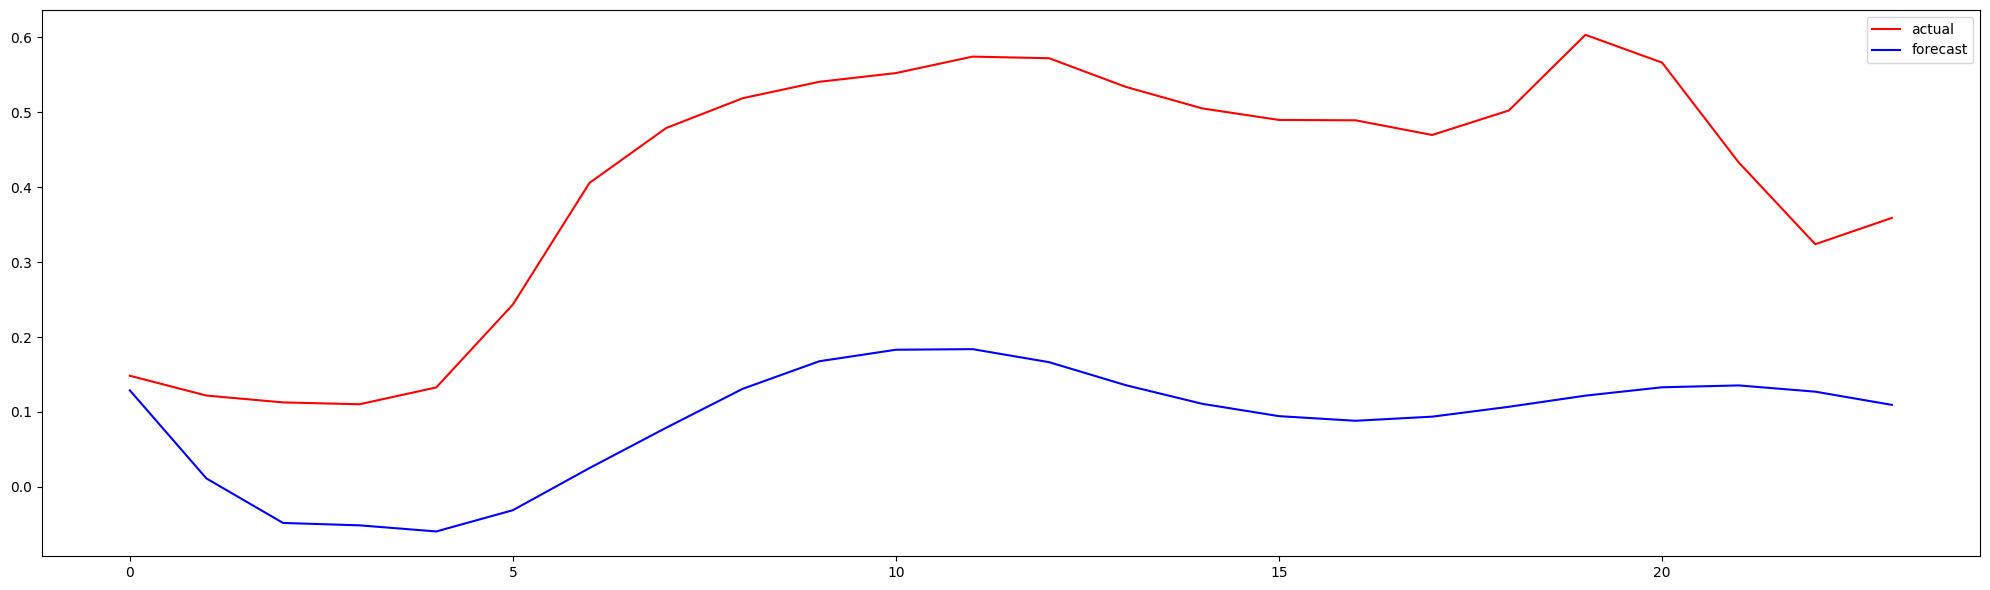

In [ ]:
output_cols=['total load actual scaled', 'price actual scaled']

actual = valid_s.iloc[48:72]['total load actual scaled'].to_list()

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(actual, c='red', label='actual')
ax.plot(predictions[:,0], c= 'blue', label='forecast')
plt.legend()
plt.tight_layout()
plt.show()


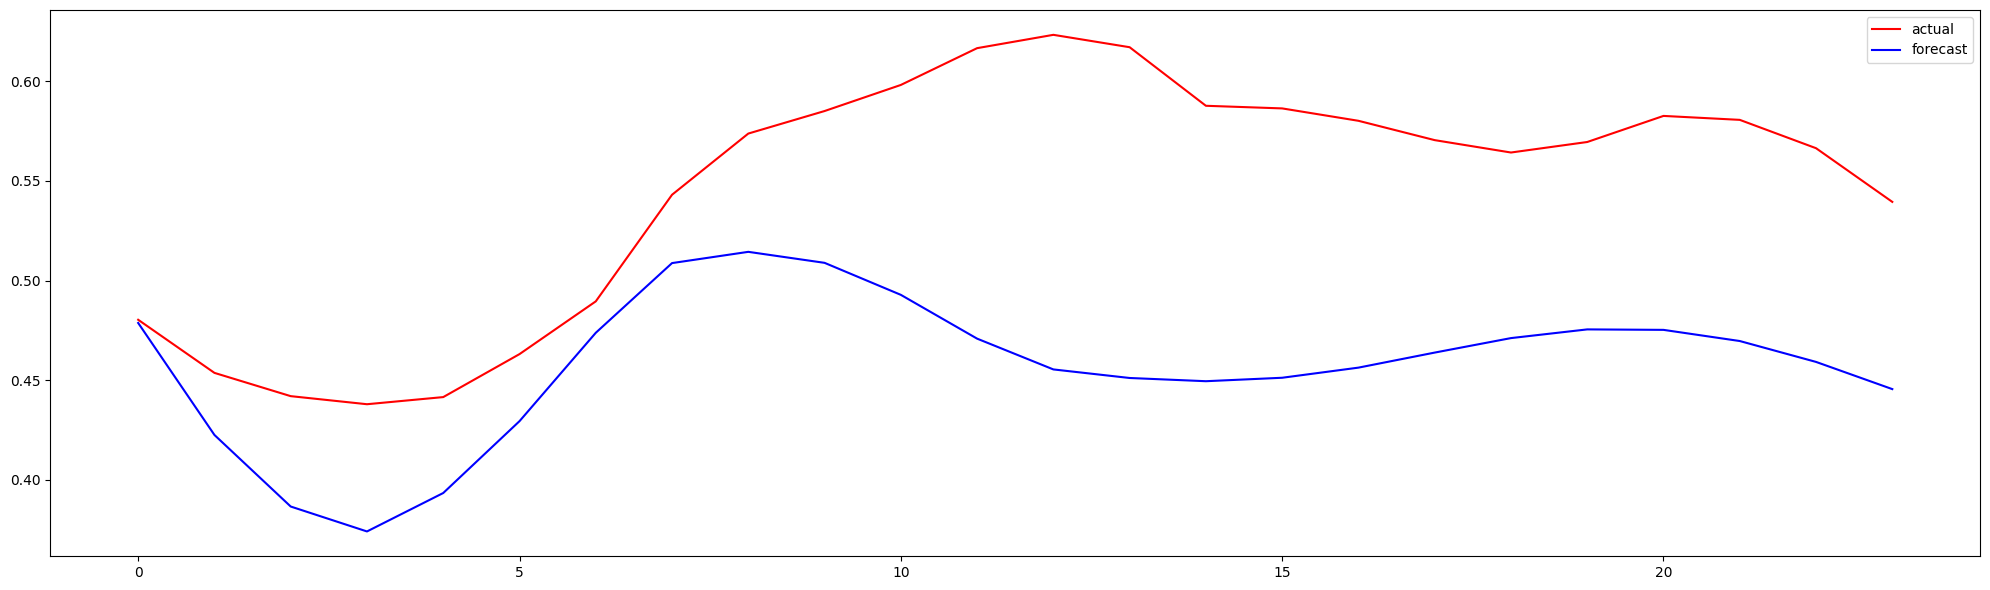

In [ ]:
output_cols=['total load actual scaled', 'price actual scaled']

actual = valid_s.iloc[48:72]['price actual scaled'].to_list()

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(actual, c='red', label='actual')
ax.plot(predictions[:,1], c= 'blue', label='forecast')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
zz = single_step_single_output_model.predict(input_data)
zz.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


(1, 2)

### Multi-Step (CNN-LSTM-DNN)

#### Single Shot Multi-Output

The entire time sereis is predicted at once, This is the most general case, all other cases are special cases of this situation

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size, forecast_size, input_cols, output_cols, column_names):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series, not necessarily univariate
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer_size(int) - buffer size to use for the shuffle method
      input_columns (list of str or int) - the names or indices of the columns to be used as features
      output_columns (str or int) - the name or index of the column to be used as the label
      column_names (list of str, optional) - the names of the columns in the series

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # If column names are provided, we track the input_columns and output_columns using their indices in the column list
    if column_names is not None:
        input_cols = [column_names.index(col) if isinstance(col, str) else col for col in input_cols]
        output_cols = [column_names.index(col) if isinstance(col, str) else col for col in output_cols]
    else:
        # If no column names are provided, assume feature_columns and label_columns are indices
        raise ValueError(f"column_names are missing")

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + forecast_size, shift=1, drop_remainder=True) # This is different from single step model: "+ forecast_size"

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + forecast_size))

    # Create tuples with specified features and label
    dataset = dataset.map(lambda window: (tf.gather(window[:-forecast_size], input_cols, axis=-1),
                                          tf.gather(window[-forecast_size:], output_cols, axis=-1))) # forecast_size=1 refers to single step

    if shuffle_buffer_size is not None:
        # Shuffle the windows
        dataset = dataset.shuffle(shuffle_buffer_size)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset



In [ ]:
input_cols = ['total load actual_roll_scaled', 'price actual_roll_scaled']
output_cols = ['total load actual scaled', 'price actual scaled']
column_names = train_s.columns.to_list()

# Parameters
window_size = 24 * 14
batch_size = 32
shuffle_buffer_size = 10000 # this value depends on the size of the data, around the len(data) for small data and smaller len(data) for big data
forecast_size = 24


train_set = windowed_dataset(train_s, window_size,
                             batch_size,
                             shuffle_buffer_size,
                             forecast_size,
                             input_cols,
                             output_cols,
                             column_names)

In [ ]:
# Build CNN-LSTM-DNN Model

def create_uncompiled_model():

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=4, strides=1, padding='causal', activation='relu',
                              input_shape=[window_size, len(input_cols)]),
        #tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=True), # False corresponds to single step model
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(2),
        tf.keras.layers.Lambda(lambda x: x[:,-forecast_size:,:])
    ])

    return model

def adjust_learning_rate(dataset):
    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 5))
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)

    # Compile the model
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    # Train the model
    history = model.fit(dataset, epochs=20, callbacks=[lr_schedule])

    return history


In [ ]:
lr_history = adjust_learning_rate(train_set)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


427/427 ━━━━━━━━━━━━━━━━━━━━ 100s 214ms/step - loss: 0.0925 - mae: 0.3800 - learning_rate: 1.0000e-04
Epoch 2/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


427/427 ━━━━━━━━━━━━━━━━━━━━ 141s 212ms/step - loss: 0.0252 - mae: 0.1753 - learning_rate: 1.5849e-04
Epoch 3/20
427/427 ━━━━━━━━━━━━━━━━━━━━ 143s 213ms/step - loss: 0.0136 - mae: 0.1282 - learning_rate: 2.5119e-04
Epoch 4/20
427/427 ━━━━━━━━━━━━━━━━━━━━ 142s 215ms/step - loss: 0.0127 - mae: 0.1247 - learning_rate: 3.9811e-04
Epoch 5/20
427/427 ━━━━━━━━━━━━━━━━━━━━ 102s 224ms/step - loss: 0.0126 - mae: 0.1238 - learning_rate: 6.3096e-04
Epoch 6/20
427/427 ━━━━━━━━━━━━━━━━━━━━ 138s 217ms/step - loss: 0.0123 - mae: 0.1227 - learning_rate: 0.0010
Epoch 7/20
427/427 ━━━━━━━━━━━━━━━━━━━━ 142s 217ms/step - loss: 0.0120 - mae: 0.1210 - learning_rate: 0.0016
Epoch 8/20
427/427 ━━━━━━━━━━━━━━━━━━━━ 140s 213ms/step - loss: 0.0118 - mae: 0.1193 - learning_rate: 0.0025
Epoch 9/20
427/427 ━━━━━━━━━━━━━━━━━━━━ 98s 217ms/step - loss: 0.0114 - mae: 0.1175 - learning_rate: 0.0040
Epoch 10/20
427/427 ━━━━━━━━━━━━━━━━━━━━ 142s 213ms/step - loss: 0.0106 - mae: 0.1127 - learning_rate: 0.0063
Epoch 11/20
42

(0.0001, 1.0, 0.0, 0.08)

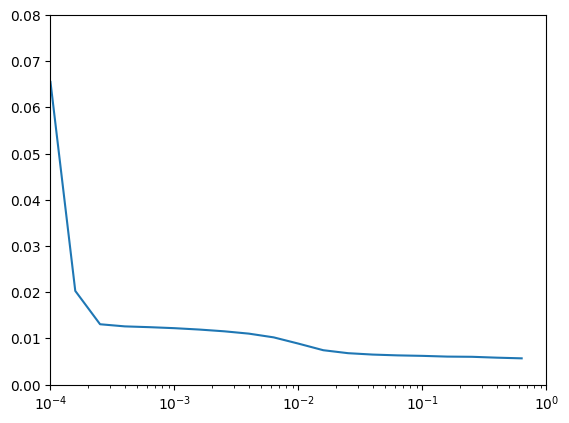

In [ ]:
plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])
plt.axis([1e-4, 1, 0, 0.08])

In [ ]:
valid_set = windowed_dataset(series = valid_s,
                             window_size = window_size,
                             batch_size = batch_size,
                             shuffle_buffer_size = shuffle_buffer_size,
                             forecast_size = forecast_size,
                             input_cols = input_cols,
                             output_cols = output_cols,
                             column_names = column_names)

def create_model(initial_lr=1e-1):

    # Set the initial learning rate
    initial_learning_rate=initial_lr

    # Define the scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=200,
        decay_rate=0.9,
        staircase=True)

    # Set the optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

    model = create_uncompiled_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    return model

model = create_model(initial_lr=5e-2)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_set, validation_data=valid_set, epochs=30, callbacks=[early_stopping])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    427/Unknown 98s 210ms/step - loss: 0.0175 - mae: 0.1418

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


427/427 ━━━━━━━━━━━━━━━━━━━━ 102s 219ms/step - loss: 0.0175 - mae: 0.1417 - val_loss: 0.0078 - val_mae: 0.1019
Epoch 2/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 142s 216ms/step - loss: 0.0077 - mae: 0.0936 - val_loss: 0.0074 - val_mae: 0.0985
Epoch 3/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 100s 217ms/step - loss: 0.0070 - mae: 0.0877 - val_loss: 0.0059 - val_mae: 0.0811
Epoch 4/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 101s 220ms/step - loss: 0.0065 - mae: 0.0842 - val_loss: 0.0059 - val_mae: 0.0818
Epoch 5/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 142s 220ms/step - loss: 0.0064 - mae: 0.0832 - val_loss: 0.0058 - val_mae: 0.0799
Epoch 6/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 140s 219ms/step - loss: 0.0063 - mae: 0.0826 - val_loss: 0.0059 - val_mae: 0.0804
Epoch 7/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 141s 217ms/step - loss: 0.0063 - mae: 0.0820 - val_loss: 0.0059 - val_mae: 0.0796
Epoch 8/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 149s 231ms/step - loss: 0.0062 - mae: 0.0816 - val_loss: 0.0059 - val_mae: 0.0789
Epoch 9/30
427/427 ━━━━━━━━━━━━━━━━

In [ ]:
t_input = train_set.map(lambda x, y: x)
t_y = train_set.map(lambda x, y: y)

t_output = []
for outputs in t_y:
    t_output.append(outputs.numpy())
t_output = np.concatenate(t_output, axis=0)

t_prediction = model.predict(t_input)

427/427 ━━━━━━━━━━━━━━━━━━━━ 32s 59ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


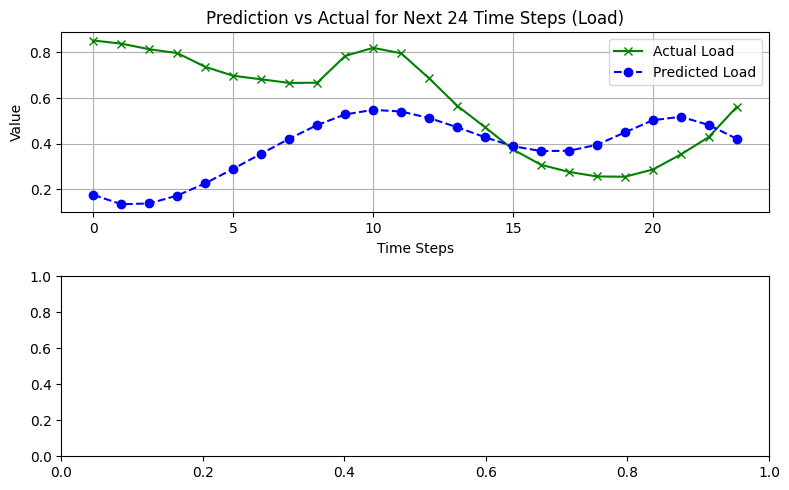

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(8, 5))
axs[0].plot(t_output[25,:,0], label='Actual Load', linestyle='-', marker='x', c='green')
axs[0].plot(t_prediction[25,:,0], label='Predicted Load', linestyle='--', marker='o', c='blue')

axs[0].set_title(f'Prediction vs Actual for Next 24 Time Steps (Load)')
axs[0].set_xlabel('Time Steps')

axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].grid(True)


plt.tight_layout()
plt.show()

In [ ]:
valid_input = valid_set.map(lambda x, y: x)
valid_y = valid_set.map(lambda x, y: y)

valid_output = []
for outputs in valid_y:
    valid_output.append(outputs.numpy())
valid_output = np.concatenate(valid_output, axis=0)

In [ ]:
valid_prediction = model.predict(valid_input)

44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step


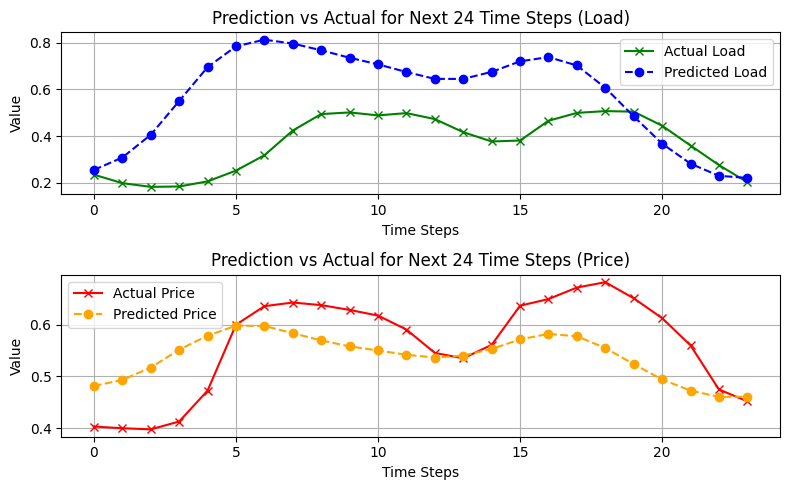

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(8, 5))
axs[0].plot(valid_output[0,:,0], label='Actual Load', linestyle='-', marker='x', c='green')
axs[0].plot(valid_prediction[0,:,0], label='Predicted Load', linestyle='--', marker='o', c='blue')

axs[0].set_title(f'Prediction vs Actual for Next 24 Time Steps (Load)')
axs[0].set_xlabel('Time Steps')

axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(valid_output[0,:,1], label='Actual Price', linestyle='-', marker='x', c='red')
axs[1].plot(valid_prediction[0,:,1], label='Predicted Price', linestyle='--', marker='o', c='orange')

axs[1].set_title(f'Prediction vs Actual for Next 24 Time Steps (Price)')
axs[1].set_xlabel('Time Steps')
axs[1].set_ylabel('Value')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Save models

model.save('multi_step_model.h5')

### XGBoost

In [ ]:
df.head()

,total load actual,price actual,total load actual_roll,price actual_roll
time,,,,
2015-01-01 01:00:00,22734.0,64.48,24167.000000,64.936667
2015-01-01 02:00:00,21286.0,59.32,22800.666667,62.906667
2015-01-01 03:00:00,20264.0,56.04,21428.000000,59.946667
2015-01-01 04:00:00,19905.0,53.63,20485.000000,56.330000
2015-01-01 05:00:00,20010.0,51.73,20059.666667,53.800000


In [ ]:
import holidays


def create_features(mother_dataset):
    """
    Create time series features from the datetime index and existing variables
    """
    df = mother_dataset.copy()

    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofmonth'] = df.index.day
    df['dayofyear'] = df.index.dayofyear
    df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_month_end'] = df.index.is_month_end.astype(int)
    df['is_quarter_start'] = df.index.is_quarter_start.astype(int)
    df['is_quarter_end'] = df.index.is_quarter_end.astype(int)
    df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)

    # Use Spain holidays
    spain_holidays = holidays.Spain()
    df['is_holiday'] = df.index.to_series().apply(lambda x: 1 if x in spain_holidays else 0)

    for lag in range(1, 25):
        df[f'load_lag_{lag}'] = df['total load actual'].shift(lag)
        df[f'price_lag_{lag}'] = df['price actual'].shift(lag)
    # Dropping NaN values resulting from rolling operation
    df.dropna(inplace=True)

    return df



In [ ]:
df = df.drop(['total load actual_roll','price actual_roll'], axis=1)
ds = create_features(df)
ds.head()

,total load actual,price actual,hour,dayofweek,quarter,month,dayofmonth,dayofyear,is_month_start,is_month_end,...,load_lag_20,price_lag_20,load_lag_21,price_lag_21,load_lag_22,price_lag_22,load_lag_23,price_lag_23,load_lag_24,price_lag_24
time,,,,,,,,,,,,,,,,,,,,,
2015-01-02 01:00:00,23214.0,54.70,1,4,1,1,2,2,0,0,...,20010.0,51.73,19905.0,53.63,20264.0,56.04,21286.0,59.32,22734.0,64.48
2015-01-02 02:00:00,22540.0,54.91,2,4,1,1,2,2,0,0,...,20377.0,51.43,20010.0,51.73,19905.0,53.63,20264.0,56.04,21286.0,59.32
2015-01-02 03:00:00,22096.0,53.07,3,4,1,1,2,2,0,0,...,20094.0,48.98,20377.0,51.43,20010.0,51.73,19905.0,53.63,20264.0,56.04
2015-01-02 04:00:00,22066.0,54.23,4,4,1,1,2,2,0,0,...,20637.0,54.20,20094.0,48.98,20377.0,51.43,20010.0,51.73,19905.0,53.63
2015-01-02 05:00:00,22275.0,58.22,5,4,1,1,2,2,0,0,...,22250.0,58.94,20637.0,54.20,20094.0,48.98,20377.0,51.43,20010.0,51.73


In [ ]:
ds.shape

(35038, 62)

In [ ]:
split_step = int(len(ds)*0.8)
train = ds.iloc[:split_step]
val = ds.iloc[split_step:]

valid = val.iloc[:int(len(val)*0.5)].copy()
test = val.iloc[int(len(val)*0.5):].copy()

In [ ]:
train_x = train.drop(['total load actual', 'price actual'], axis=1)
train_load = train['total load actual']
train_price = train['price actual']

valid_x = valid.drop(['total load actual', 'price actual'], axis=1)
valid_load = valid['total load actual']
valid_price = valid['price actual']

test_x = test.drop(['total load actual', 'price actual'], axis=1)
test_load = test['total load actual']
test_price = test['price actual']

#### Load

In [ ]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Define parameter grid
param_grid = {
    'objective': ['reg:squarederror'],
    'max_depth': range(1, 5, 1),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [500, 1000],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.2, 0.4],
    'reg_alpha': [0, 0.2, 0.4],
    'reg_lambda': [0, 0.2, 0.4]
}

# Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor()

# Initialize RandomizedSearchCV for total load actual
random_search_load = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=param_grid,
    n_iter=40,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=50,
    random_state=42,
    n_jobs=-1 # use all available CPU
)

# Fit models
random_search_load.fit(train_x, train_load)

# Print best parameters and scores for total load actual
print("Best parameters for total load actual: ", random_search_load.best_params_)
print("Lowest RMSE for total load actual: ", np.sqrt(np.abs(random_search_load.best_score_)))



Fitting 3 folds for each of 40 candidates, totalling 120 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters for total load actual:  {'reg_lambda': 0.4, 'reg_alpha': 0.2, 'objective': 'reg:squarederror', 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}
Lowest RMSE for total load actual:  528.8128928491752


In [ ]:
# Define parameter grid
param_grid = {
    'objective': ['reg:squarederror'],
    'max_depth': [4],
    'learning_rate': [0.05, 0.1, 0.3, 0.5],
    'n_estimators': [1000, 1300],
    'min_child_weight': [4, 5, 6],
    'gamma': [0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0.3, 0.4, 0.5]
}

# Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor()

# Initialize RandomizedSearchCV for total load actual
random_search_load = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=param_grid,
    n_iter=40,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=50,
    random_state=42,
    n_jobs=-1 # use all available CPU
)

# Fit models
random_search_load.fit(train_x, train_load)

# Print best parameters and scores for total load actual
print("Best parameters for total load actual: ", random_search_load.best_params_)
print("Lowest RMSE for total load actual: ", np.sqrt(np.abs(random_search_load.best_score_)))

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameters for total load actual:  {'reg_lambda': 0.4, 'reg_alpha': 0, 'objective': 'reg:squarederror', 'n_estimators': 1300, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}
Lowest RMSE for total load actual:  522.3293930256864


In [ ]:
dtrain_load = xgb.DMatrix(train_x, label=train_load)

# Define the parameters for the model
parameters = {'reg_lambda': 0.4,
              'reg_alpha': 0,
              'objective': 'reg:squarederror',
              'min_child_weight': 5,
              'max_depth': 4,
              'learning_rate': 0.1,
              'gamma': 0.2}

# Set up cross-validation parameters
cv_results = xgb.cv(
    params=parameters,
    dtrain=dtrain_load,
    num_boost_round=8000,
    nfold=5,
    metrics={'rmse', 'mae'},
    early_stopping_rounds=100, # rmse
    verbose_eval=200,
    seed=42
)

# Print the best score
print("Best RMSE from cross-validation: ", cv_results['test-rmse-mean'].min())
print("Best MAE from cross-validation: ", cv_results['test-mae-mean'].min())

[0]	train-mae:3544.15476+5.74404	train-rmse:4165.63489+6.89966	test-mae:3544.88094+26.18374	test-rmse:4166.15086+30.11044
[200]	train-mae:325.59645+2.38632	train-rmse:486.01394+3.80907	test-mae:360.93137+6.67634	test-rmse:552.94394+19.18081
[400]	train-mae:272.76455+2.50930	train-rmse:402.79561+4.01961	test-mae:329.58496+4.88251	test-rmse:515.25144+19.10591
[600]	train-mae:241.38144+1.98839	train-rmse:353.15276+2.75154	test-mae:315.27192+4.66231	test-rmse:498.74164+20.27026
[800]	train-mae:216.93299+1.59623	train-rmse:314.18235+2.73018	test-mae:306.18423+4.91483	test-rmse:488.05900+21.46764
[1000]	train-mae:197.95012+1.23532	train-rmse:284.08850+2.06617	test-mae:300.72343+5.14991	test-rmse:481.91095+21.63490
[1200]	train-mae:181.90026+1.07999	train-rmse:259.30731+1.99568	test-mae:296.70520+5.38579	test-rmse:477.63059+21.95347
[1400]	train-mae:168.25056+0.71487	train-rmse:238.47453+1.52109	test-mae:293.74920+5.48055	test-rmse:474.84536+22.54286
[1600]	train-mae:156.27641+0.57839	train-r

In [ ]:
best_num_boost_round = cv_results['test-rmse-mean'].idxmin()
best_num_boost_round

7570

In [ ]:
load_final_model = xgb.train(
    params=parameters,
    dtrain=dtrain_load,
    num_boost_round=best_num_boost_round
)

In [ ]:
# Prediction
dval_load = xgb.DMatrix(valid_x, label=valid_load)
valid_load_pred = load_final_model.predict(dval_load).reshape(-1, 1)
valid_load = valid_load.values.reshape(-1, 1)

mae = mean_absolute_error(valid_load_pred, valid_load)
print(f"Mean Absolute Error (MAE): {mae}")

# 计算MSE
mse = mean_squared_error(valid_load_pred, valid_load)
print(f"Mean Squared Error (MSE): {mse}")

Mean Absolute Error (MAE): 277.17798520440925
Mean Squared Error (MSE): 216487.78286436378


#### Price

In [ ]:
# Define parameter grid
param_grid = {
    'objective': ['reg:squarederror'],
    'max_depth': range(1, 6, 1),
    'learning_rate': [0.001, 0.01, 0.1, 0.5],
    'n_estimators': [500, 1000],
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0, 0.2, 0.4],
    'reg_alpha': [0, 0.2, 0.4],
    'reg_lambda': [0, 0.2, 0.4]
}

# Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor()

# Initialize RandomizedSearchCV for price actual
random_search_load = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=50,
    random_state=42,
    n_jobs=-1 # use all available CPU
)

# Fit models
random_search_load.fit(train_x, train_price)

# Print best parameters and scores for total load actual
print("Best parameters for total load actual: ", random_search_load.best_params_)
print("Lowest RMSE for total load actual: ", np.sqrt(np.abs(random_search_load.best_score_)))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters for total load actual:  {'reg_lambda': 0.2, 'reg_alpha': 0, 'objective': 'reg:squarederror', 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.4}
Lowest RMSE for total load actual:  2.6532054769748767


In [ ]:
dtrain_price = xgb.DMatrix(train_x, label=train_price)

# Define the parameters for the model
parameters = {'reg_lambda': 0.2,
              'reg_alpha': 0,
              'objective': 'reg:squarederror',
              'min_child_weight': 5,
              'max_depth': 4,
              'learning_rate': 0.1,
              'gamma': 0.4}

# Set up cross-validation parameters
cv_results = xgb.cv(
    params=parameters,
    dtrain=dtrain_price,
    num_boost_round=3000,
    nfold=3,
    metrics={'rmse', 'mae'},
    early_stopping_rounds=100, # rmse
    verbose_eval=200,
    seed=42
)

# Print the best score
print("Best RMSE from cross-validation: ", cv_results['test-rmse-mean'].min())
print("Best MAE from cross-validation: ", cv_results['test-mae-mean'].min())

[0]	train-mae:9.90742+0.00845	train-rmse:12.93110+0.01781	test-mae:9.90985+0.01869	test-rmse:12.93326+0.03624
[200]	train-mae:1.51106+0.00939	train-rmse:2.07542+0.02224	test-mae:1.71605+0.01794	test-rmse:2.41922+0.04787
[400]	train-mae:1.33097+0.00704	train-rmse:1.80845+0.01635	test-mae:1.66854+0.01774	test-rmse:2.36266+0.04941
[600]	train-mae:1.20447+0.00598	train-rmse:1.62629+0.01416	test-mae:1.65539+0.01624	test-rmse:2.34819+0.04939
[800]	train-mae:1.10261+0.00530	train-rmse:1.48369+0.01255	test-mae:1.65043+0.01504	test-rmse:2.34244+0.04975
[1000]	train-mae:1.01494+0.00448	train-rmse:1.36381+0.00972	test-mae:1.64720+0.01620	test-rmse:2.33923+0.05100
[1180]	train-mae:0.94341+0.00455	train-rmse:1.26648+0.00880	test-mae:1.64678+0.01552	test-rmse:2.33944+0.05109
Best RMSE from cross-validation:  2.3383957042816155
Best MAE from cross-validation:  1.6462252595887026


In [ ]:
best_num_boost_round = cv_results['test-rmse-mean'].idxmin()
best_num_boost_round

1081

In [ ]:
final_price_model = xgb.train(
    params=parameters,
    dtrain=dtrain_price,
    num_boost_round=best_num_boost_round
)

In [ ]:
valid_price

,price actual
time,
2018-03-14 23:00:00,32.54
2018-03-15 00:00:00,20.14
2018-03-15 01:00:00,14.66
2018-03-15 02:00:00,13.54
2018-03-15 03:00:00,13.77
...,...
2018-08-07 18:00:00,74.22
2018-08-07 19:00:00,75.17
2018-08-07 20:00:00,74.12


In [ ]:
# Prediction
dval_price = xgb.DMatrix(valid_x)
valid_price_pred = final_price_model.predict(dval_price).reshape(-1, 1)
valid_price = valid_price.values.reshape(-1, 1)

mae = mean_absolute_error(valid_price_pred, valid_price)
print(f"Mean Absolute Error (MAE): {mae}")

# 计算MSE
mse = mean_squared_error(valid_price_pred, valid_price)
print(f"Mean Squared Error (MSE): {mse}")

Mean Absolute Error (MAE): 1.5432879746559005
Mean Squared Error (MSE): 4.659157376697544


If the model performs good on the validation set, we move on to predict future values. Firstly, we re-train the full dataset including  training set and validation set

In [ ]:
full_dataset = pd.concat([train, valid])
full_dataset.shape

(31534, 62)

In [ ]:
dfull_train_load = xgb.DMatrix(full_dataset.drop(['total load actual', 'price actual'], axis=1), label=full_dataset['total load actual'])
dfull_train_price = xgb.DMatrix(full_dataset.drop(['total load actual', 'price actual'], axis=1), label=full_dataset['price actual'])

In [ ]:
load_model= xgb.train(
    params=parameters,
    dtrain=dfull_train_load,
    num_boost_round=7570,
)

In [ ]:
price_model= xgb.train(
    params=parameters,
    dtrain=dfull_train_price,
    num_boost_round=1081,
)

,total load actual,price actual,hour,dayofweek,quarter,month,dayofmonth,dayofyear,is_month_start,is_month_end,...,load_lag_20,price_lag_20,load_lag_21,price_lag_21,load_lag_22,price_lag_22,load_lag_23,price_lag_23,load_lag_24,price_lag_24
time,,,,,,,,,,,,,,,,,,,,,
2018-08-07 22:00:00,29365.0,68.97,22,1,3,8,7,219,0,0,...,21767.0,58.7,22237.0,59.21,23102.0,60.13,24361.0,64.44,25967.0,67.17


In [ ]:
history_data = valid[-1:].copy()

new_index = pd.date_range(start=history_data.index[-1], periods=25,
                          freq='H')  # Assuming hourly frequency

extended_data = history_data.reindex(new_index)


def update_features(mother_dataset):
    """
    Create time series features from the datetime index and existing variables
    """
    df = mother_dataset.copy()

    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofmonth'] = df.index.day
    df['dayofyear'] = df.index.dayofyear
    df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_month_end'] = df.index.is_month_end.astype(int)
    df['is_quarter_start'] = df.index.is_quarter_start.astype(int)
    df['is_quarter_end'] = df.index.is_quarter_end.astype(int)
    df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)

    # Use Spain holidays
    spain_holidays = holidays.Spain()
    df['is_holiday'] = df.index.to_series().apply(lambda x: 1 if x in spain_holidays else 0)

    return df

extended_data = update_features(extended_data)

In [ ]:
extended_data.iloc[[1]]['hour']

,hour
2018-08-07 23:00:00,23


In [ ]:
window_size = 24

# Iterate through each hour in the extended data
for i in range(1, 25):
    for j in range(1, window_size):
        # Directly assign to the DataFrame using `.iloc`
        extended_data.iloc[i, extended_data.columns.get_loc(f'load_lag_{j+1}')] = extended_data.iloc[i-1, extended_data.columns.get_loc(f'load_lag_{j}')]
        extended_data.iloc[i, extended_data.columns.get_loc(f'price_lag_{j+1}')] = extended_data.iloc[i-1, extended_data.columns.get_loc(f'price_lag_{j}')]
    extended_data.iloc[i, extended_data.columns.get_loc('load_lag_1')] = extended_data.iloc[i-1, extended_data.columns.get_loc('load_lag_1')]
    extended_data.iloc[i, extended_data.columns.get_loc('price_lag_1')] = extended_data.iloc[i-1, extended_data.columns.get_loc('price_lag_1')]

    last_inputs = extended_data.iloc[[i-1]].copy()
    last_inputs = last_inputs.drop(['total load actual', 'price actual'], axis=1)
    dtrain = xgb.DMatrix(last_inputs)
    load = load_model.predict(dtrain)
    price = price_model.predict(dtrain)

    extended_data.iloc[i, extended_data.columns.get_loc('total load actual')] = load[0]
    extended_data.iloc[i, extended_data.columns.get_loc('price actual')] = price[0]

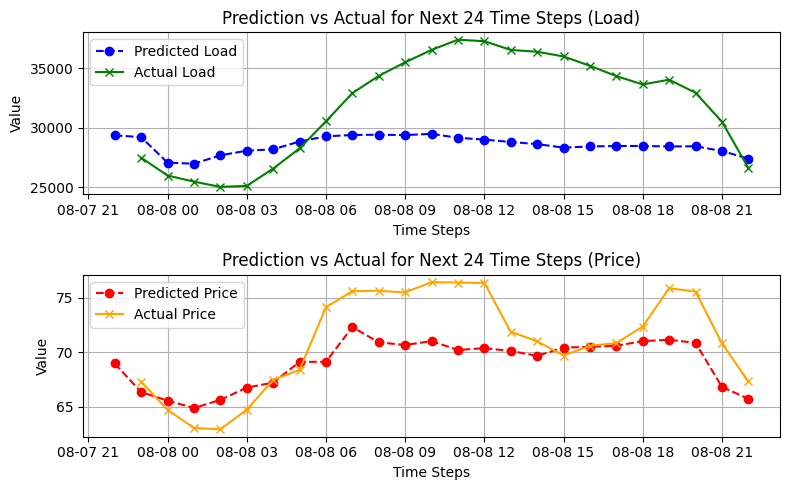

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(8, 5))

axs[0].plot(extended_data['total load actual'], label='Predicted Load', linestyle='--', marker='o', c='blue')
axs[0].plot(test[:24]['total load actual'], label='Actual Load', linestyle='-', marker='x', c='green')


axs[0].set_title(f'Prediction vs Actual for Next 24 Time Steps (Load)')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(extended_data['price actual'], label='Predicted Price', linestyle='--', marker='o', c='red')
axs[1].plot(test[:24]['price actual'], label='Actual Price', linestyle='-', marker='x', c= 'orange')
axs[1].set_title(f'Prediction vs Actual for Next 24 Time Steps (Price)')
axs[1].set_xlabel('Time Steps')
axs[1].set_ylabel('Value')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

## 4. Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Reshape the predictions and valid outputs to 2D
# This flattens the windows and time steps into a single dimension
prediction_reshaped = prediction.reshape(-1, prediction.shape[-1])  # Shape: (6966*24, 2)
test_output_reshaped = test_output.reshape(-1, test_output.shape[-1])  # Shape: (6966*24, 2)

# Revert the predictions and actual values to their original scales
prediction_reshaped[:, 0] = load_scaler.inverse_transform(prediction_reshaped[:, 0].reshape(-1, 1)).flatten()
prediction_reshaped[:, 1] = price_scaler.inverse_transform(prediction_reshaped[:, 1].reshape(-1, 1)).flatten()

test_output_reshaped[:, 0] = load_scaler.inverse_transform(test_output_reshaped[:, 0].reshape(-1, 1)).flatten()
test_output_reshaped[:, 1] = price_scaler.inverse_transform(test_output_reshaped[:, 1].reshape(-1, 1)).flatten()

# Calculate MSE for each target
mse_load = mean_squared_error(test_output_reshaped[:, 0], prediction_reshaped[:, 0])
mse_price = mean_squared_error(test_output_reshaped[:, 1], prediction_reshaped[:, 1])

# Calculate MAE for each target
mae_load = mean_absolute_error(test_output_reshaped[:, 0], prediction_reshaped[:, 0])
mae_price = mean_absolute_error(test_output_reshaped[:, 1], prediction_reshaped[:, 1])

# Print the MSE results
print(f'MSE for Load: {mse_load}')
print(f'MSE for Price: {mse_price}')

# Print the MAe results
print(f'MAE for Load: {mae_load}')
print(f'MAE for Price: {mae_price}')

MSE for Load: 7109858.220131684
MSE for Price: 32.32858569674062
MAE for Load: 2032.1090146865224
MAE for Price: 4.537975513299491


## 5. |Deployment and Prediction

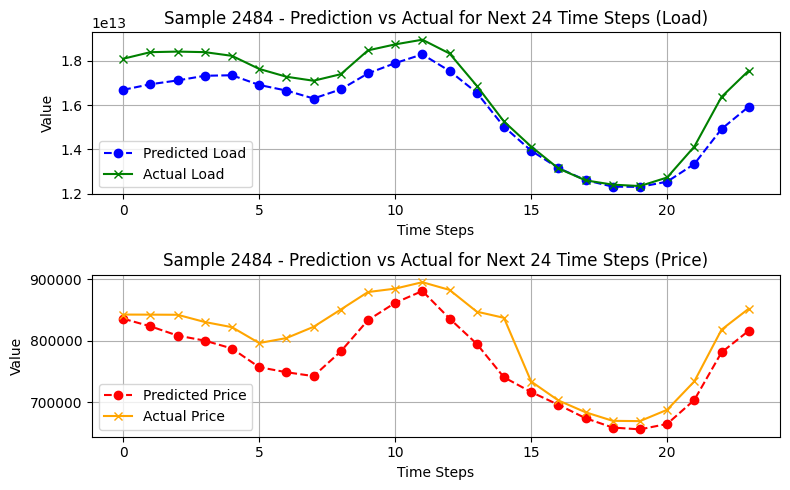

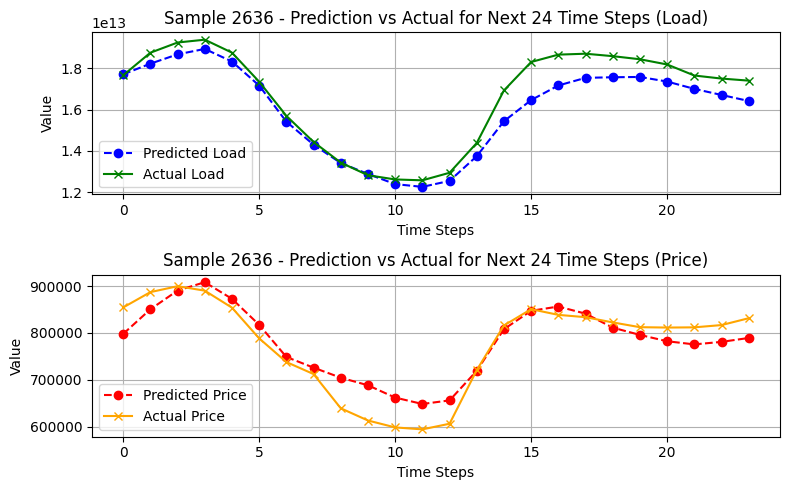

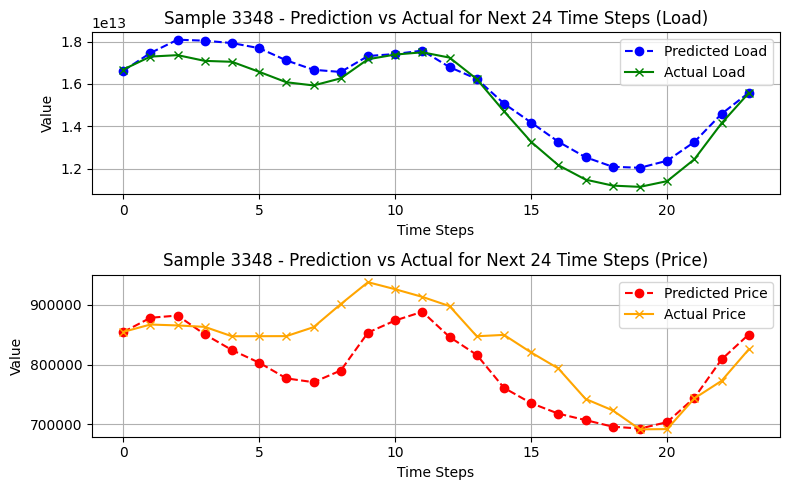

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Randomly select 3 samples (indices) from the reshaped predictions and valid outputs
num_samples = prediction.shape[0]  # This is 6966 based on your description
random_indices = np.random.choice(num_samples, 3, replace=False)

# Plot predictions vs actual values for the selected samples in original scale
for i, idx in enumerate(random_indices):
    # Revert the predictions and actual values for the selected sample
    original_prediction_load = load_scaler.inverse_transform(prediction[idx, :, 0].reshape(-1, 1)).flatten()
    original_actual_load = load_scaler.inverse_transform(test_output[idx, :, 0].reshape(-1, 1)).flatten()

    original_prediction_price = price_scaler.inverse_transform(prediction[idx, :, 1].reshape(-1, 1)).flatten()
    original_actual_price = price_scaler.inverse_transform(test_output[idx, :, 1].reshape(-1, 1)).flatten()

    fig, axs = plt.subplots(2, 1, figsize=(8, 5))

    axs[0].plot(original_prediction_load, label='Predicted Load', linestyle='--', marker='o', c='blue')
    axs[0].plot(original_actual_load, label='Actual Load', linestyle='-', marker='x', c='green')
    axs[0].set_title(f'Sample {idx} - Prediction vs Actual for Next 24 Time Steps (Load)')
    axs[0].set_xlabel('Time Steps')
    axs[0].set_ylabel('Value')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(original_prediction_price, label='Predicted Price', linestyle='--', marker='o', c='red')
    axs[1].plot(original_actual_price, label='Actual Price', linestyle='-', marker='x', c= 'orange')
    axs[1].set_title(f'Sample {idx} - Prediction vs Actual for Next 24 Time Steps (Price)')
    axs[1].set_xlabel('Time Steps')
    axs[1].set_ylabel('Value')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

